In [ ]:
! pip install keras
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import datetime as dt
import calendar,warnings,itertools,matplotlib,keras,shutil
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.datasets import load_iris,make_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from keras import Sequential
from keras.layers import Dense
from IPython.core import display as ICD
from sklearn.metrics import roc_curve, roc_auc_score
#from tensorflow_core.estimator import inputs

#Hiding the warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset=pd.read_csv("/content/drive/MyDrive/DataCoSupplyChainDataset.csv",header= 0,encoding= 'unicode_escape')
dataset.head(5)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [ ]:
dataset.shape

(180519, 53)

In [ ]:
dataset.apply(lambda x: sum(x.isnull()))

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [ ]:
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+dataset['Customer Lname'].astype(str)

In [ ]:
data=dataset.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape

(180519, 42)

In [ ]:
data['Customer Zipcode']=data['Customer Zipcode'].fillna(0)

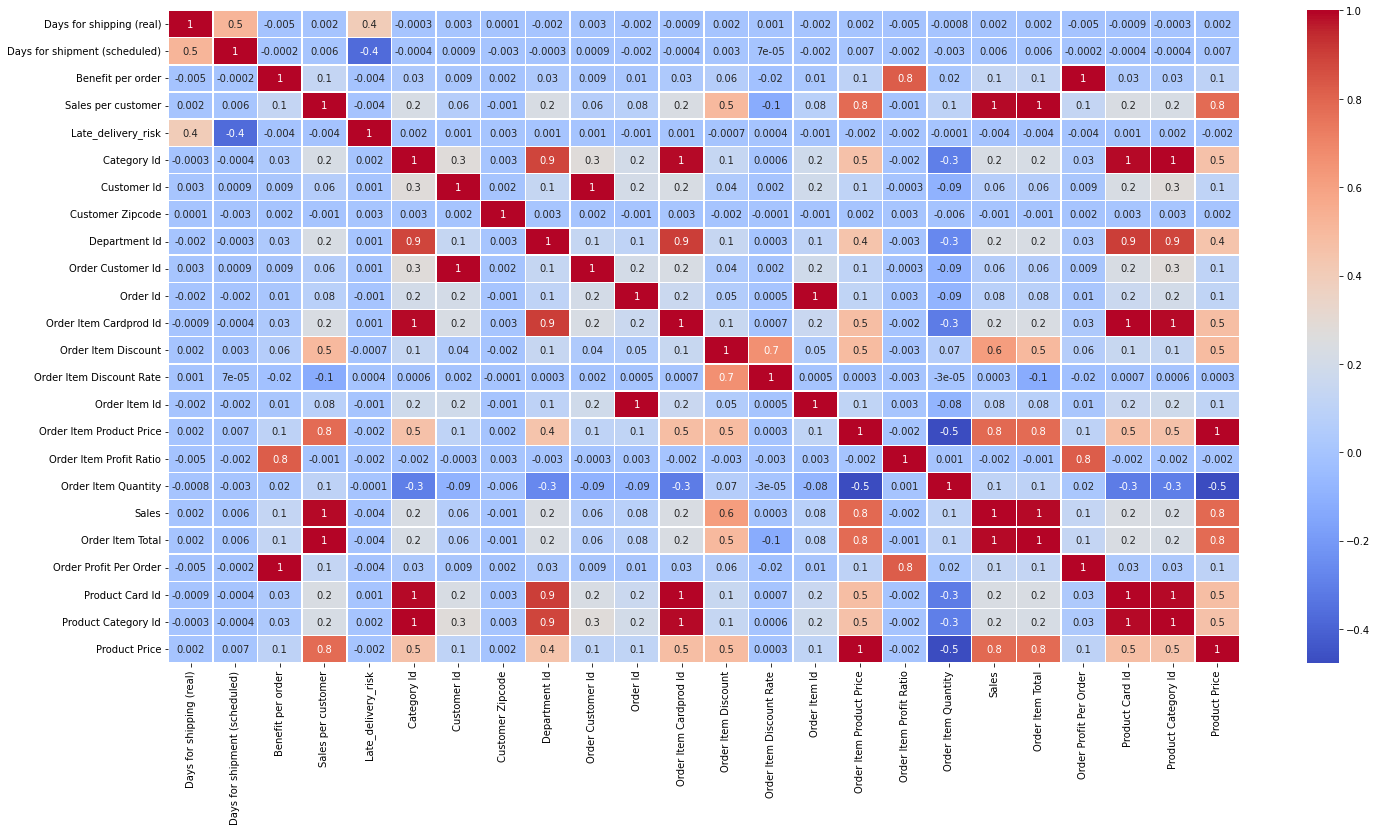

In [ ]:
fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm')

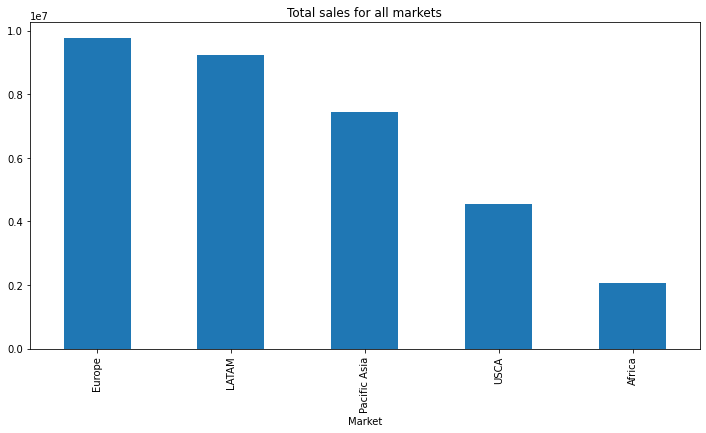

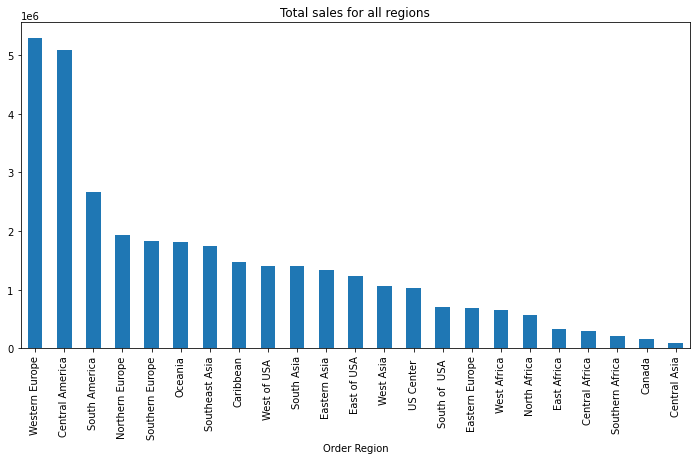

In [ ]:
market = data.groupby('Market')
region = data.groupby('Order Region')
plt.figure(1)
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all markets")
plt.figure(2)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all regions")

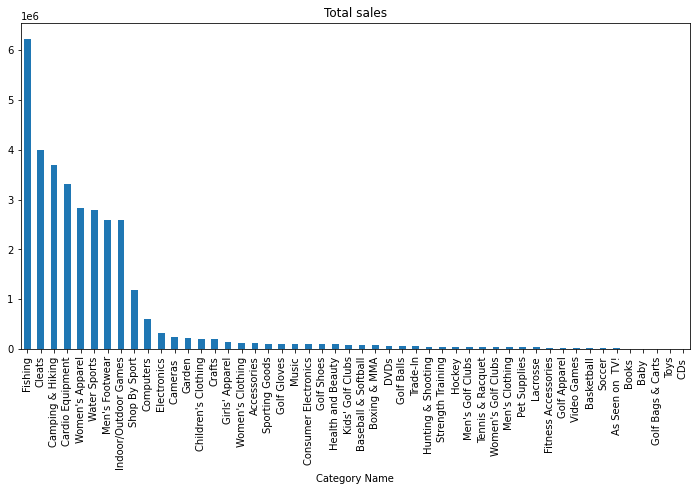

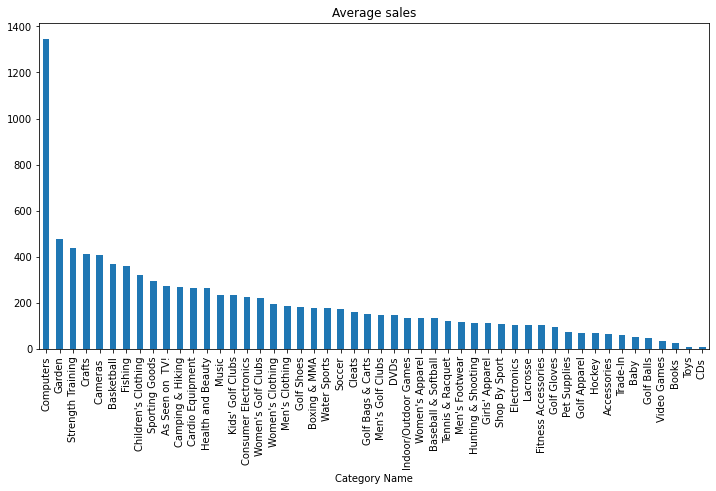

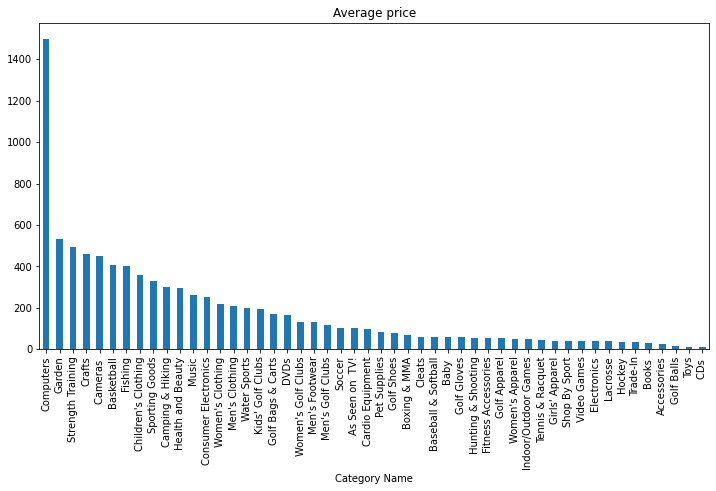

In [ ]:
#Grouping all categories
cat = data.groupby('Category Name')
plt.figure(1)
# Total sum of sales for all categories
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales")
# Mean sales for all categories
plt.figure(2)
cat['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average sales")
plt.figure(3)
# Mean prices for all categories
cat['Product Price'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average price")

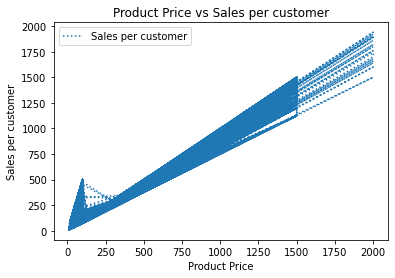

In [ ]:
data.plot(x='Product Price', y='Sales per customer',linestyle='dotted',
     markerfacecolor='blue', markersize=12)
plt.title('Product Price vs Sales per customer')#title
plt.xlabel('Product Price')  # X-axis title
plt.ylabel('Sales per customer') # Y=axis title
plt.show()

In [ ]:
data['order_year']= pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).weekday
data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
data['order_month_year'] = pd.to_datetime(data['order date (DateOrders)']).dt.to_period('M')

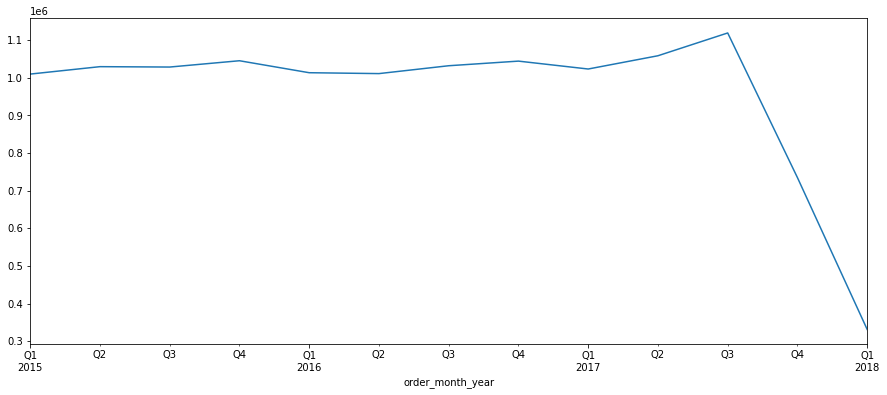

In [ ]:
quater= data.groupby('order_month_year')
quartersales=quater['Sales'].sum().resample('Q').mean().plot(figsize=(15,6))

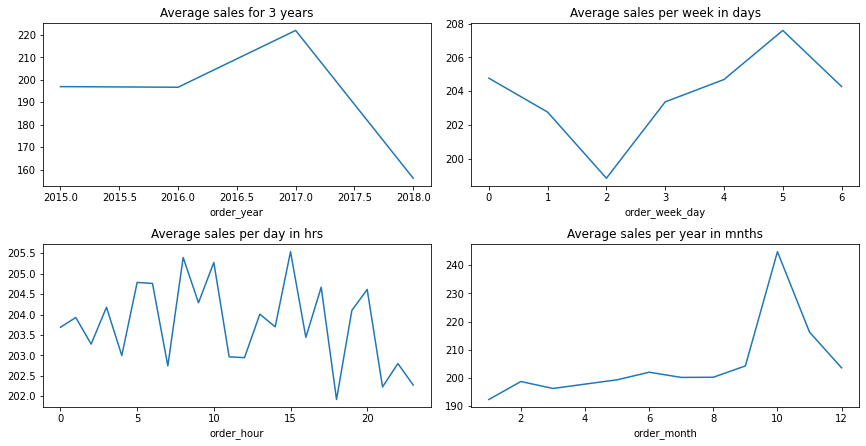

In [ ]:
plt.figure(figsize=(10,12))
plt.subplot(4, 2, 1)
quater= data.groupby('order_year')
quater['Sales'].mean().plot(figsize=(12,12),title='Average sales for 3 years')
plt.subplot(4, 2, 2)
days=data.groupby("order_week_day")
days['Sales'].mean().plot(figsize=(12,12),title='Average sales per week in days')
plt.subplot(4, 2, 3)
hrs=data.groupby("order_hour")
hrs['Sales'].mean().plot(figsize=(12,12),title='Average sales per day in hrs')
plt.subplot(4, 2, 4)
mnth=data.groupby("order_month")
mnth['Sales'].mean().plot(figsize=(12,12),title='Average sales per year in mnths')
plt.tight_layout()
plt.show()

In [ ]:
data['Type'].unique()

array(['DEBIT', 'TRANSFER', 'CASH', 'PAYMENT'], dtype=object)

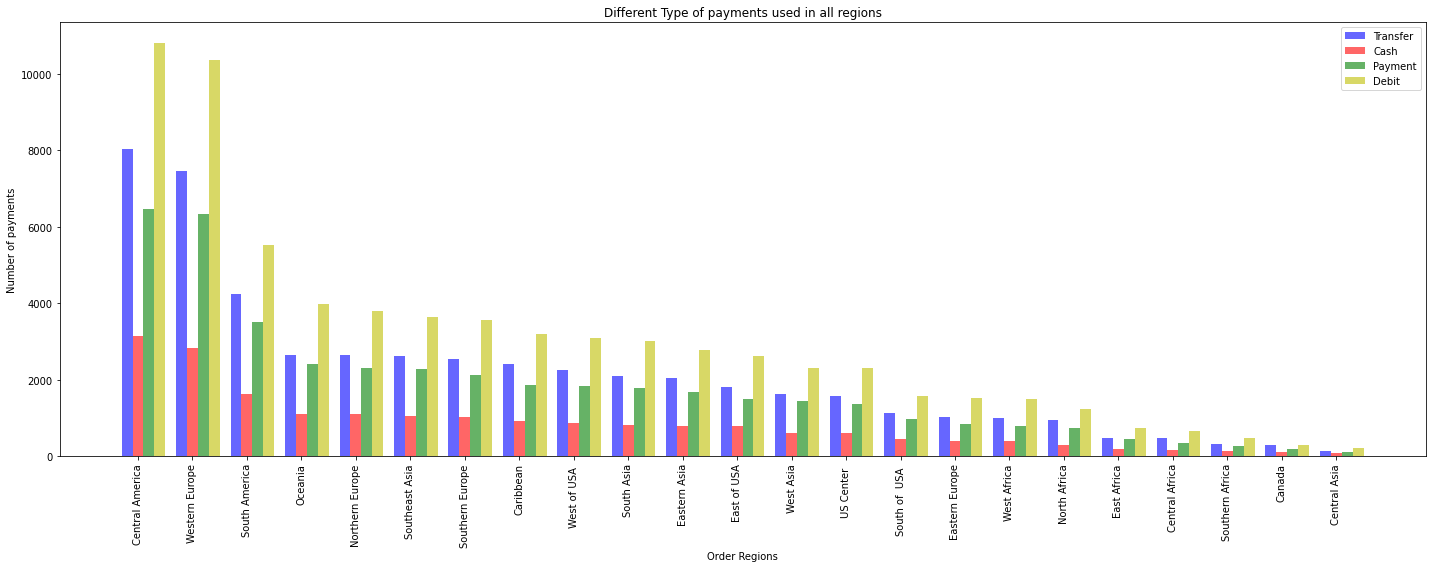

In [ ]:
xyz1 = data[(data['Type'] == 'TRANSFER')]
xyz2= data[(data['Type'] == 'CASH')]
xyz3= data[(data['Type'] == 'PAYMENT')]
xyz4= data[(data['Type'] == 'DEBIT')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Transfer')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='Cash')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='Payment')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='Debit')
plt.xlabel('Order Regions')
plt.ylabel('Number of payments')
plt.title('Different Type of payments used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

Total revenue lost with orders -3883547.345768667


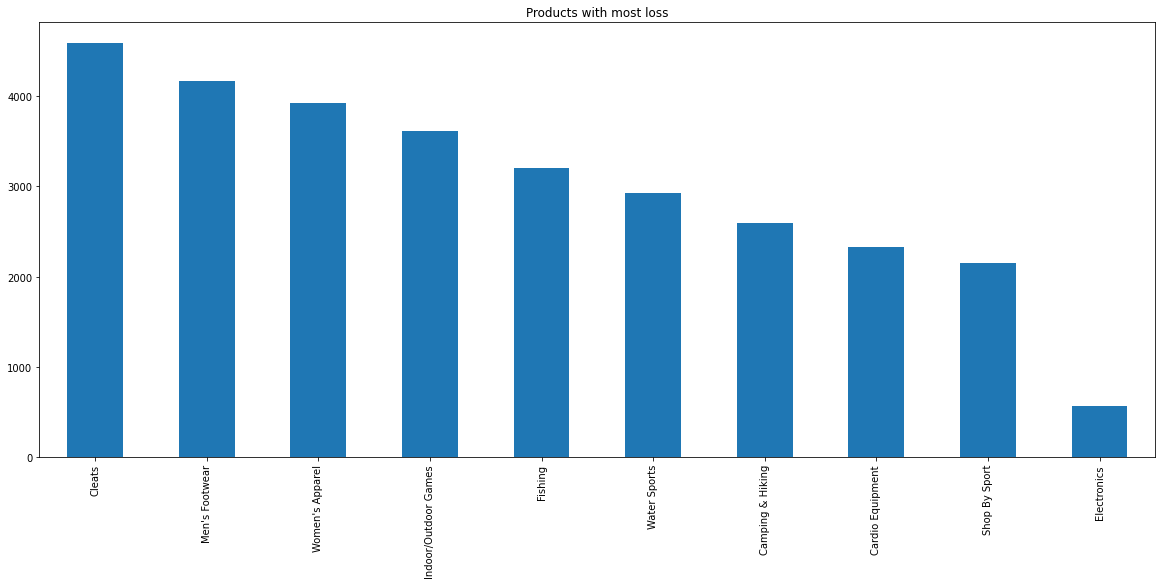

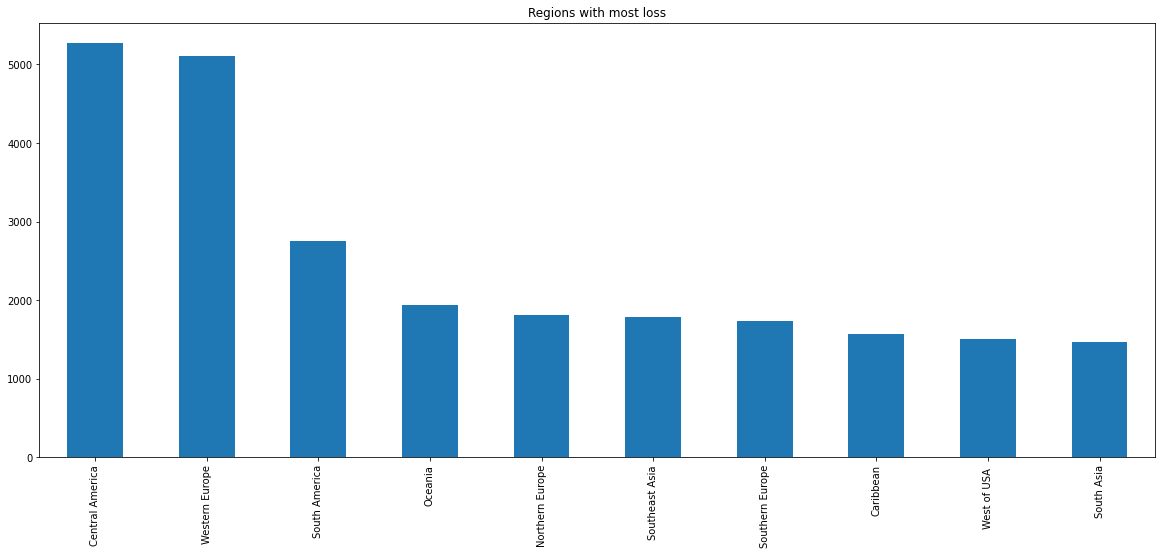

In [ ]:
loss = data[(data['Benefit per order']<0)]
#Plotting top 10 products with most loss
plt.figure(1)
loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Products with most loss")
plt.figure(2)
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Regions with most loss")
#Sum of total sales which are lost
print('Total revenue lost with orders',loss['Benefit per order'].sum())

In [ ]:
#Checking type of payment used to conduct fraud other than Transfer
xyz = data[(data['Type'] != 'TRANSFER')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
xyz['Order Region'].value_counts()

Series([], Name: Order Region, dtype: int64)

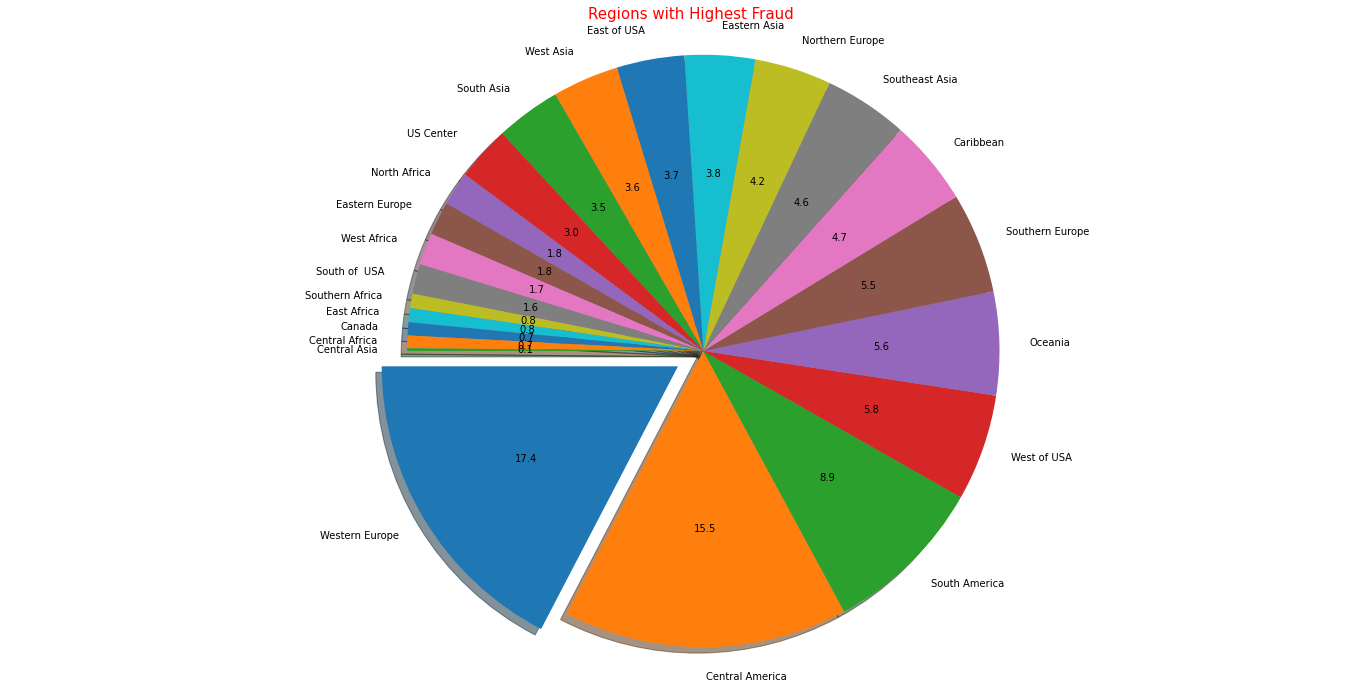

In [ ]:
high_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') & (data['Type'] == 'TRANSFER')]#separating orders with suspected fraud
#Plotting pie chart with respect to order region
fraud=high_fraud['Order Region'].value_counts().plot.pie(figsize=(24,12),
                                                  startangle=180, explode=(0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),autopct='%.1f',shadow=True,)
plt.title("Regions with Highest Fraud",size=15,color='r') # Plotting title
plt.ylabel(" ")
fraud.axis('equal')
plt.show()

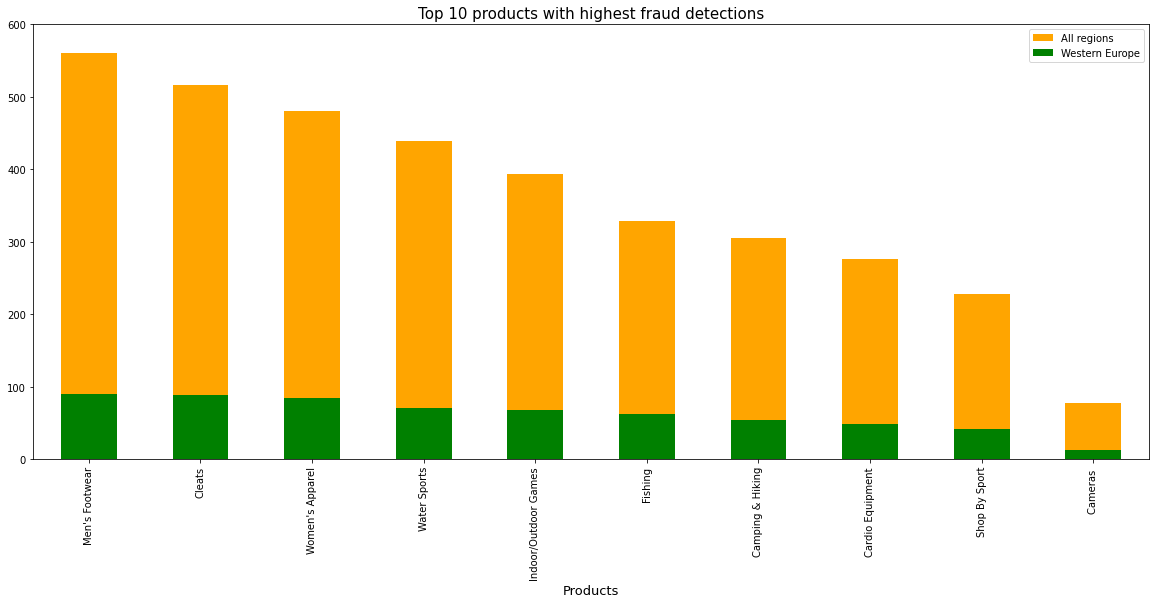

In [ ]:
high_fraud1 = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] #
high_fraud2 = data[(data['Order Status'] == 'SUSPECTED_FRAUD') &(data['Order Region'] == 'Western Europe')]
#Plotting bar chart for top 10 most suspected fraud department in all regions
fraud1=high_fraud1['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud Category",color='orange')
#Plotting bar chart for top 10 most suspected fraud department in Western Europe
fraud2=high_fraud2['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud product in Western Europe",color='green')
plt.legend(["All regions", "Western Europe"])
plt.title("Top 10 products with highest fraud detections", size=15)
plt.xlabel("Products", size=13)
plt.ylim(0,600)
plt.show()

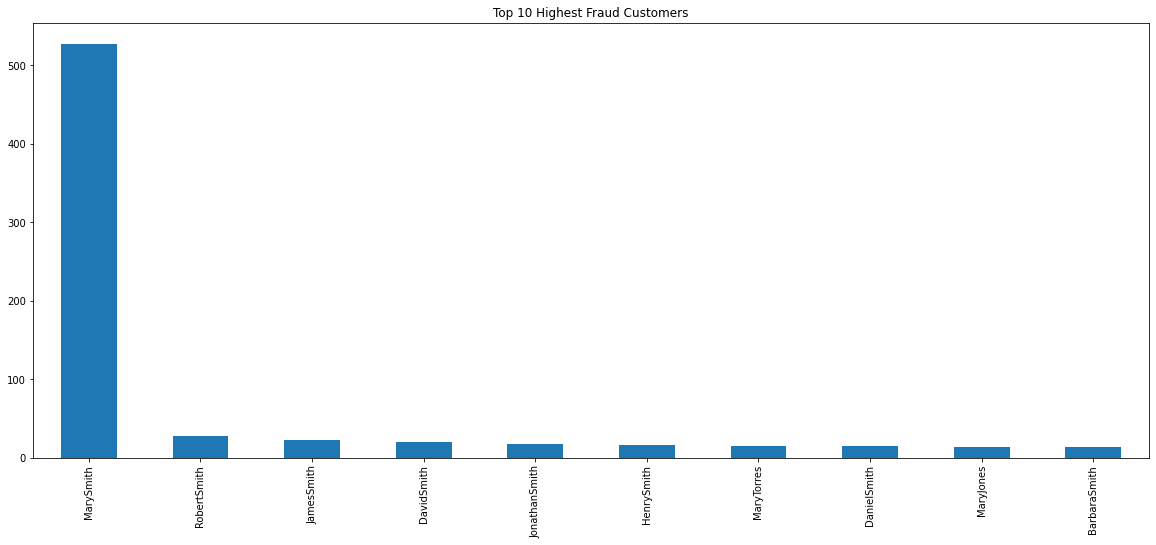

In [ ]:
#Filtering out suspected fruad orders
cus = data[(data['Order Status'] == 'SUSPECTED_FRAUD')]
#Top 10 customers with most fraud
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 Highest Fraud Customers")

In [ ]:
#Filtering orders of mary smith with suspected fraud
amount = data[(data['Customer Full Name'] == 'MarySmith')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
#Plotting bar chart for top 10 most suspected fraud customers
amount['Sales'].sum()

102491.66191043999

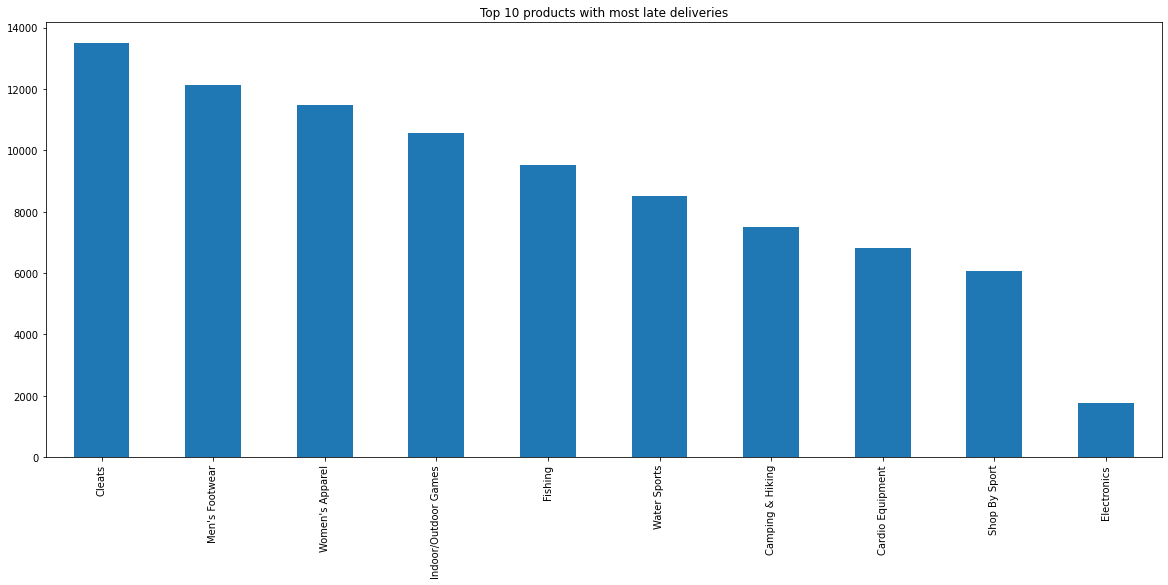

In [ ]:
#Filtering columns with late delivery status
late_delivery = data[(data['Delivery Status'] == 'Late delivery')]
#Top 10 products with most late deliveries
late_delivery['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 products with most late deliveries")

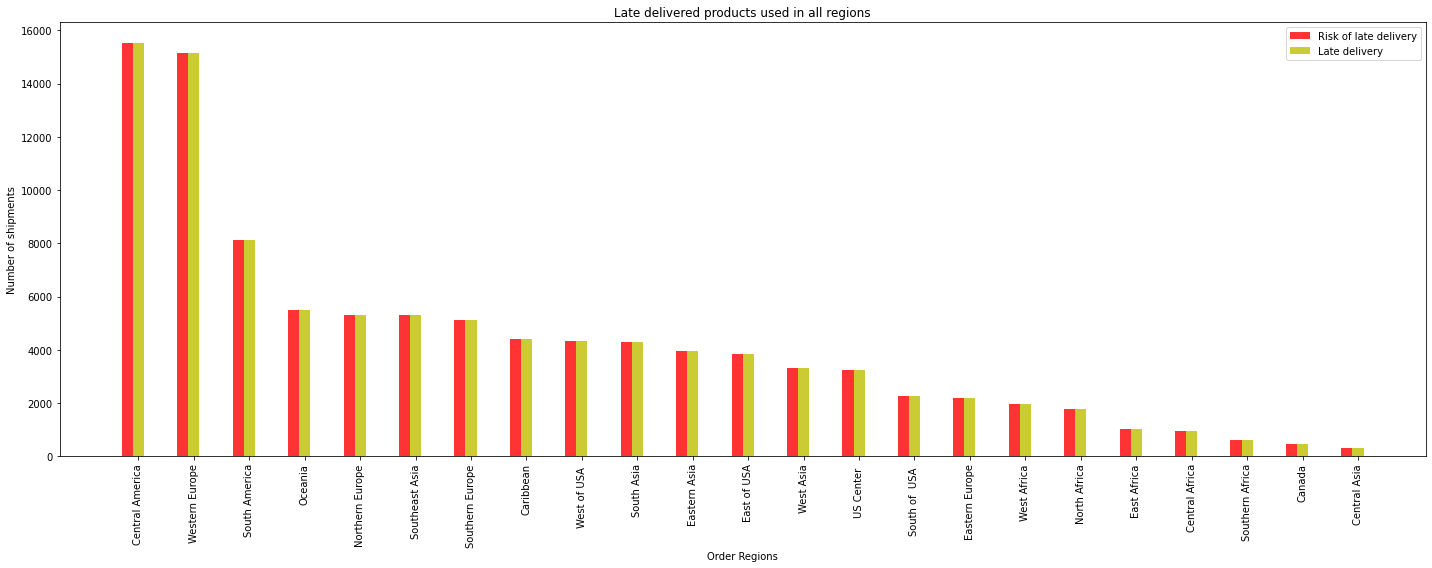

In [ ]:
#Filtering orders with late delivery risk
xyz1 = data[(data['Late_delivery_risk'] == 1)]
#Filtering late delivered orders
xyz2 = data[(data['Delivery Status'] == 'Late delivery')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8)) #Figure size
index=np.arange(n_groups)
bar_width=0.2
opacity=0.8
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='r',label='Risk of late delivery')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='y',label='Late delivery')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Late delivered products used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

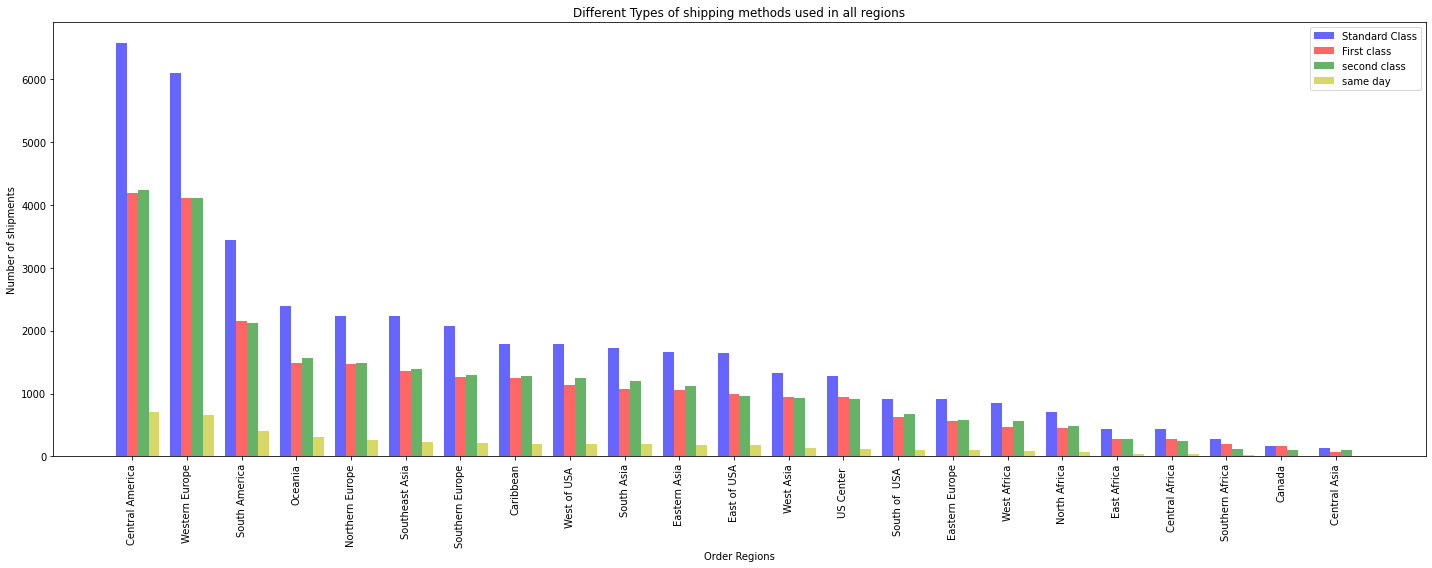

In [ ]:
#Filtering late delivery orders with standard class shipping
xyz1 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Standard Class')]
#Filtering late delivery orders with first class shipping
xyz2 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'First Class')]
#Filtering late delivery orders with second class shipping
xyz3 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Second Class')]
#Filtering late delivery orders with same day shipping
xyz4 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Same Day')]
#Counting total values
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Standard Class')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='First class')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='second class')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='same day')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Different Types of shipping methods used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
data['TotalPrice'] = data['Order Item Quantity'] * data['Order Item Total']

In [ ]:
data['order date (DateOrders)'].max()

'9/9/2017 9:50'

In [ ]:
present = dt.datetime(2018,2,1)
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])

In [ ]:
Customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (present - x.max()).days, 'Order Id': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})
#Changing order dates to int format
Customer_seg['order date (DateOrders)'] = Customer_seg['order date (DateOrders)'].astype(int)
# Renaming columns as R_Value,F_Value,M_Value
Customer_seg.rename(columns={'order date (DateOrders)': 'R_Value',
                         'Order Id': 'F_Value',
                         'TotalPrice': 'M_Value'}, inplace=True)
Customer_seg.head()

,R_Value,F_Value,M_Value
Order Customer Id,,,
1,792,1,2362.250061
2,136,10,2842.700073
3,229,18,6143.760057
4,380,14,4370.629991
5,457,7,2993.790032


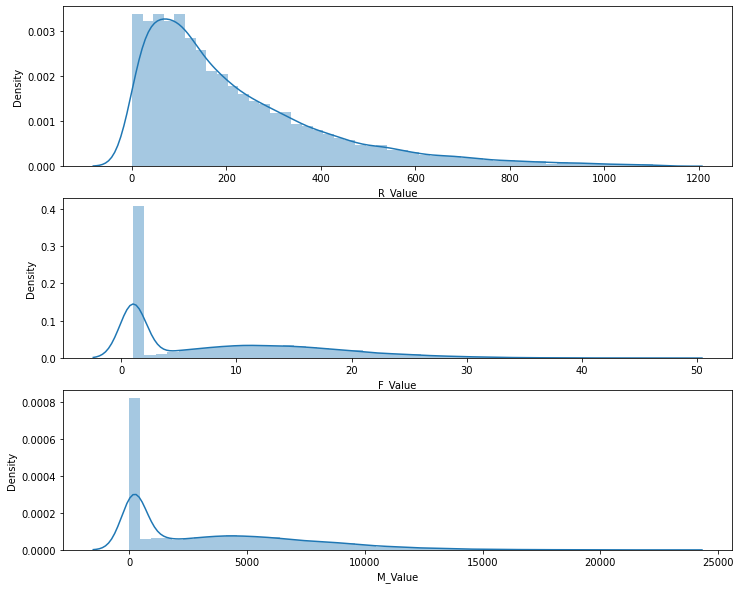

In [ ]:
plt.figure(figsize=(12,10)) # Figure size
plt.subplot(3, 1, 1)
sns.distplot(Customer_seg['R_Value'])# Plot distribution of R_Value
plt.subplot(3, 1, 2)
sns.distplot(Customer_seg['F_Value'])# Plot distribution of F_Value
plt.subplot(3, 1, 3)
sns.distplot(Customer_seg['M_Value'])# Plot distribution of M_Value
plt.show()

In [ ]:
quantiles = Customer_seg.quantile(q=[0.25,0.5,0.75]) #Dividing RFM data into four quartiles
quantiles = quantiles.to_dict()

In [ ]:
# R_Score should be minimum so 1st quantile is set as 1.
def R_Score(a,b,c):
    if a <= c[b][0.25]:
        return 1
    elif a <= c[b][0.50]:
        return 2
    elif a <= c[b][0.75]:
        return 3
    else:
        return 4
# The higher the F_Score,M_Score the better so 1st quantile is set as 4.
def FM_Score(x,y,z):
    if x <= z[y][0.25]:
        return 4
    elif x <= z[y][0.50]:
        return 3
    elif x <= z[y][0.75]:
        return 2
    else:
        return 1

In [ ]:
# New column for R_Score to indicate numerical score between 1 to 4.
Customer_seg['R_Score'] = Customer_seg['R_Value'].apply(R_Score, args=('R_Value',quantiles))
# New column for F_Score to indicate numerical score between 1 to 4.
Customer_seg['F_Score'] = Customer_seg['F_Value'].apply(FM_Score, args=('F_Value',quantiles))
# New column for M_Score to indicate numerical score between 1 to 4.
Customer_seg['M_Score'] = Customer_seg['M_Value'].apply(FM_Score, args=('M_Value',quantiles))
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score
Order Customer Id,,,,,,
1,792,1,2362.250061,4,4,3
2,136,10,2842.700073,2,2,2
3,229,18,6143.760057,3,1,1
4,380,14,4370.629991,4,2,2
5,457,7,2993.790032,4,3,2


In [ ]:
#Adding R,F,M Scores to one new column
Customer_seg['RFM_Score'] = Customer_seg.R_Score.astype(str)+ Customer_seg.F_Score.astype(str) + Customer_seg.M_Score.astype(str)
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score
Order Customer Id,,,,,,,
1,792,1,2362.250061,4,4,3,443
2,136,10,2842.700073,2,2,2,222
3,229,18,6143.760057,3,1,1,311
4,380,14,4370.629991,4,2,2,422
5,457,7,2993.790032,4,3,2,432


In [ ]:
count=Customer_seg['RFM_Score'].unique()
print(count)# Printing all Unique values
len(count)# Total count

['443' '222' '311' '422' '432' '421' '211' '322' '434' '212' '411' '331'
 '412' '433' '321' '423' '333' '312' '221' '223' '332' '233' '232' '323'
 '444' '431' '343' '243' '344' '334' '244' '143' '144']


33

In [ ]:
Customer_seg['RFM_Total_Score'] = Customer_seg[['R_Score','F_Score','M_Score']].sum(axis=1)
Customer_seg['RFM_Total_Score'].unique()

array([11,  6,  5,  8,  9,  7,  4, 10, 12])

In [ ]:
def RFM_Total_Score(df):

    if (df['RFM_Total_Score'] >= 11):# For RFM score with values 11,12
        return 'Champions'
    elif (df['RFM_Total_Score'] == 10):# For RFM score with value 10
        return 'Loyal Customers'
    elif (df['RFM_Total_Score'] == 9): # For RFM score with value 9
        return 'Recent Customers'
    elif (df['RFM_Total_Score'] == 8): # For RFM score with value 8
         return 'Promising'
    elif (df['RFM_Total_Score'] == 7): # For RFM score with value 7
        return 'Customers Needing Attention'
    elif (df['RFM_Total_Score'] == 6): # For RFM score with value 6
        return 'Cant lose them'
    elif (df['RFM_Total_Score'] == 5): # For RFM score with value 5
        return 'At Risk'
    else:                               # For RFM score with value less than 5

        return 'Lost'
# Create a new variable RFM_Level
Customer_seg['Customer_Segmentation'] =Customer_seg.apply(RFM_Total_Score, axis=1)
# Print the header with top 5 rows to the console
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
1,792,1,2362.250061,4,4,3,443,11,Champions
2,136,10,2842.700073,2,2,2,222,6,Cant lose them
3,229,18,6143.760057,3,1,1,311,5,At Risk
4,380,14,4370.629991,4,2,2,422,8,Promising
5,457,7,2993.790032,4,3,2,432,9,Recent Customers


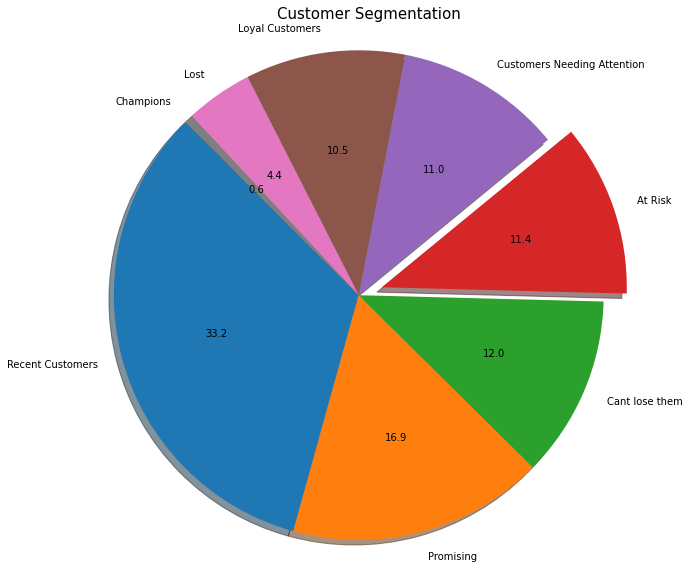

In [ ]:
Customer_seg['Customer_Segmentation'].value_counts().plot.pie(figsize=(10,10),
                                        startangle=135, explode=(0,0,0,0.1,0,0,0,0),autopct='%.1f',shadow=True)
plt.title("Customer Segmentation",size=15)
plt.ylabel(" ")
plt.axis('equal')
plt.show()

In [ ]:
churned=Customer_seg[(Customer_seg['RFM_Score']=='411')].sort_values('M_Value', ascending=False).head(10)
churned

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
11065,309,41,18641.300091,4,1,1,411,6,Cant lose them
6285,332,37,18287.010097,4,1,1,411,6,Cant lose them
7892,392,29,17620.470196,4,1,1,411,6,Cant lose them
2893,312,24,17536.609842,4,1,1,411,6,Cant lose them
4181,425,29,17333.960094,4,1,1,411,6,Cant lose them
4781,502,31,17048.380088,4,1,1,411,6,Cant lose them
9271,344,35,17044.910217,4,1,1,411,6,Cant lose them
4659,417,27,16973.060024,4,1,1,411,6,Cant lose them
1695,326,33,16916.020176,4,1,1,411,6,Cant lose them


In [ ]:
Customer_seg[(Customer_seg['RFM_Score']=='144')|(Customer_seg['RFM_Score']=='143')].sort_values('M_Value', ascending=False).head(10)

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total_Score,Customer_Segmentation
Order Customer Id,,,,,,,,,
18101,38,1,1500.0,1,4,3,143,8,Promising
18083,39,1,1500.0,1,4,3,143,8,Promising
18047,39,1,1500.0,1,4,3,143,8,Promising
18065,39,1,1500.0,1,4,3,143,8,Promising
18119,38,1,1500.0,1,4,3,143,8,Promising
18046,39,1,1485.0,1,4,3,143,8,Promising
18100,38,1,1485.0,1,4,3,143,8,Promising
18118,38,1,1485.0,1,4,3,143,8,Promising
18064,39,1,1485.0,1,4,3,143,8,Promising


In [ ]:
train_data=data.copy()

In [ ]:
train_data['fraud'] = np.where(train_data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
train_data['late_delivery']=np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)

In [ ]:
train_data.drop(['Delivery Status','Late_delivery_risk','Order Status','order_month_year','order date (DateOrders)'], axis=1, inplace=True)

In [ ]:
train_data.dtypes

Type                                     object
Days for shipping (real)                  int64
Days for shipment (scheduled)             int64
Benefit per order                       float64
Sales per customer                      float64
Delivery Status                          object
Late_delivery_risk                        int64
Category Id                               int64
Category Name                            object
Customer City                            object
Customer Country                         object
Customer Id                               int64
Customer Segment                         object
Customer State                           object
Customer Zipcode                        float64
Department Id                             int64
Department Name                          object
Market                                   object
Order City                               object
Order Country                            object
Order Customer Id                       

In [ ]:
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
train_data['Customer Country']  = le.fit_transform(train_data['Customer Country'])
train_data['Market']            = le.fit_transform(train_data['Market'])
train_data['Type']              = le.fit_transform(train_data['Type'])
train_data['Product Name']      = le.fit_transform(train_data['Product Name'])
train_data['Customer Segment']  = le.fit_transform(train_data['Customer Segment'])
train_data['Customer State']    = le.fit_transform(train_data['Customer State'])
train_data['Order Region']      = le.fit_transform(train_data['Order Region'])
train_data['Order City']        = le.fit_transform(train_data['Order City'])
train_data['Category Name']     = le.fit_transform(train_data['Category Name'])
train_data['Customer City']     = le.fit_transform(train_data['Customer City'])
train_data['Department Name']   = le.fit_transform(train_data['Department Name'])
train_data['Order State']       = le.fit_transform(train_data['Order State'])
train_data['Shipping Mode']     = le.fit_transform(train_data['Shipping Mode'])
train_data['order_week_day']    = le.fit_transform(train_data['order_week_day'])
train_data['Order Country']     = le.fit_transform(train_data['Order Country'])
train_data['Customer Full Name']= le.fit_transform(train_data['Customer Full Name'])

#display the initial records
train_data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Id,Category Name,Customer City,Customer Country,Customer Id,...,Product Price,Shipping Mode,Customer Full Name,order_year,order_month,order_week_day,order_hour,TotalPrice,fraud,late_delivery
0,1,3,4,91.250000,314.640015,73,40,66,1,20755,...,327.75,3,1876,2018,1,2,22,314.640015,0,0
1,3,5,4,-249.089996,311.359985,73,40,66,1,19492,...,327.75,3,5378,2018,1,5,12,311.359985,0,1
2,0,4,4,-247.779999,309.720001,73,40,452,0,19491,...,327.75,3,4429,2018,1,5,12,309.720001,0,0
3,1,3,4,22.860001,304.809998,73,40,285,0,19490,...,327.75,3,12929,2018,1,5,11,304.809998,0,0
4,2,2,4,134.210007,298.250000,73,40,66,1,19489,...,327.75,3,10638,2018,1,5,11,298.250000,0,0


In [ ]:
#All columns expect fraud
xf=train_data.loc[:, train_data.columns != 'fraud']
#Only fraud column
yf=train_data['fraud']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xf_train, xf_test,yf_train,yf_test = train_test_split(xf,yf,test_size = 0.2,random_state = 42)
#All columns expect fraud
xl=train_data.loc[:, train_data.columns != 'late_delivery']
#Only fraud column
yl=train_data['late_delivery']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
xl_train, xl_test,yl_train,yl_test = train_test_split(xl,yl,test_size = 0.2, random_state = 42)

In [ ]:
sc = StandardScaler()
xf_train=sc.fit_transform(xf_train)
xf_test=sc.transform(xf_test)
xl_train=sc.fit_transform(xl_train)
xl_test=sc.transform(xl_test)

In [ ]:
def classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test):
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    accuracy_f=accuracy_score(yf_pred, yf_test) #Accuracy for fraud detection
    accuracy_l=accuracy_score(yl_pred, yl_test) #Accuracy for predection of late delivery
    recall_f=recall_score(yf_pred, yf_test) #Recall score for  fraud detection
    recall_l=recall_score(yl_pred, yl_test)# Recall score for predection of late delivery
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery
    f1_f=f1_score(yf_test, yf_pred)#fraud detection
    f1_l=f1_score(yl_test, yl_pred)#predection of late delivery
    false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
    false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection
    print('roc_auc_score for Fraud detection: ', roc_auc_score(yf_test, yf_pred))
    print('roc_auc_score for Late Delivery: ', roc_auc_score(yl_test, yl_pred))
    print('Model paramters used are :',model_f)
    print('Accuracy of fraud status is        :', (accuracy_f)*100,'%')
    print('Recall score of fraud status is        :', (recall_f)*100,'%')
    print('Conf Matrix of fraud status is        :\n',  (conf_f))
    print('F1 score of fraud status is        :', (f1_f)*100,'%')
    print('Accuracy of late delivery status is:', (accuracy_l)*100,'%')
    print('Recall score of late delivery status is:', (recall_l)*100,'%')
    print('Conf Matrix of late delivery status is: \n',(conf_l))
    print('F1 score of late delivery status is:', (f1_l)*100,'%')

In [ ]:
model_f = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
model_l = LogisticRegression(solver='lbfgs',random_state=0) #the classification model
#Giving inputs to the defined function
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

roc_auc_score for Fraud detection:  0.6075254539326367
roc_auc_score for Late Delivery:  0.9872447415220457
Model paramters used are : LogisticRegression(random_state=0)
Accuracy of fraud status is        : 97.79248836693995 %
Recall score of fraud status is        : 58.307210031347964 %
Conf Matrix of fraud status is        :
 [[35121   133]
 [  664   186]]
F1 score of fraud status is        : 31.822070145423435 %
Accuracy of late delivery status is: 98.84777309993352 %
Recall score of late delivery status is: 97.9419185672587 %
Conf Matrix of late delivery status is: 
 [[15891   416]
 [    0 19797]]
F1 score of late delivery status is: 98.96025993501625 %


In [ ]:
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

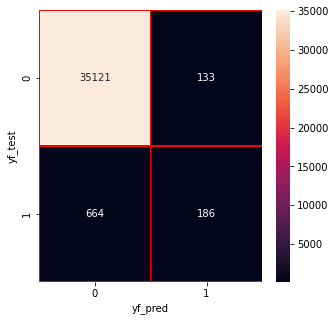

In [ ]:
#confusion matrix visualization
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_f,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yf_pred")
plt.ylabel("yf_test")
plt.show()

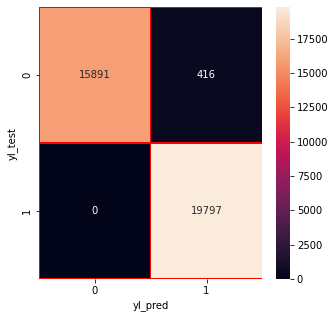

In [ ]:
#confusion matrix visualization

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_l,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yl_pred")
plt.ylabel("yl_test")
plt.show()

In [ ]:
    false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
    false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection

In [ ]:
print(false_positive_rate_f, true_positive_rate_f)

[0.         0.00377262 1.        ] [0.         0.21882353 1.        ]


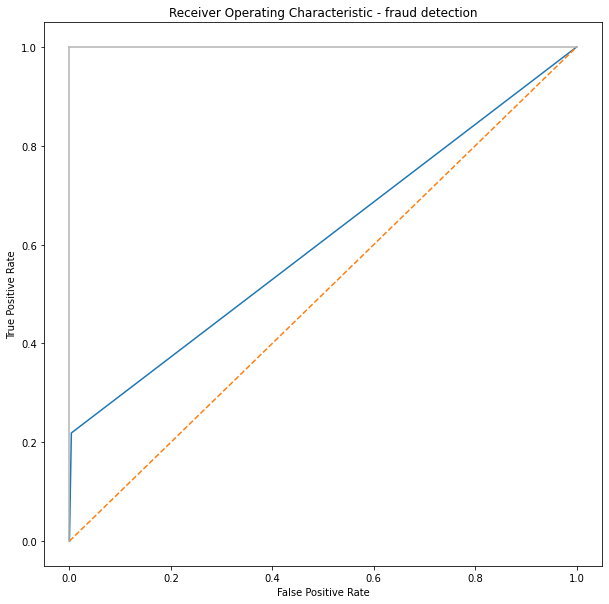

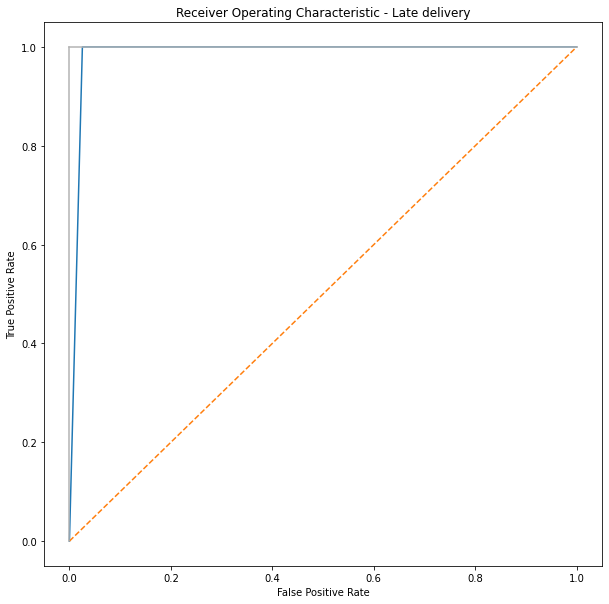

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - fraud detection')
plt.plot(false_positive_rate_f, true_positive_rate_f)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Late delivery')
plt.plot(false_positive_rate_l, true_positive_rate_l)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_f = GaussianNB()
model_l = GaussianNB()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

roc_auc_score for Fraud detection:  0.9377801100584331
roc_auc_score for Late Delivery:  0.5269678318516682
Model paramters used are : GaussianNB()
Accuracy of fraud status is        : 87.84899180146243 %
Recall score of fraud status is        : 16.23066641206798 %
Conf Matrix of fraud status is        :
 [[30867  4387]
 [    0   850]]
F1 score of fraud status is        : 27.928371940200424 %
Accuracy of late delivery status is: 57.26789275426546 %
Recall score of late delivery status is: 56.20261790510804 %
Conf Matrix of late delivery status is: 
 [[  882 15425]
 [    3 19794]]
F1 score of late delivery status is: 71.957248800349 %


In [ ]:
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

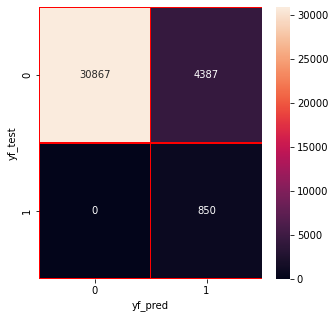

In [ ]:
#confusion matrix visualization
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_f,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yf_pred")
plt.ylabel("yf_test")
plt.show()

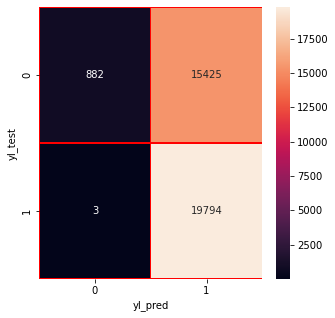

In [ ]:
#confusion matrix visualization

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_l,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yl_pred")
plt.ylabel("yl_test")
plt.show()

In [ ]:
false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection

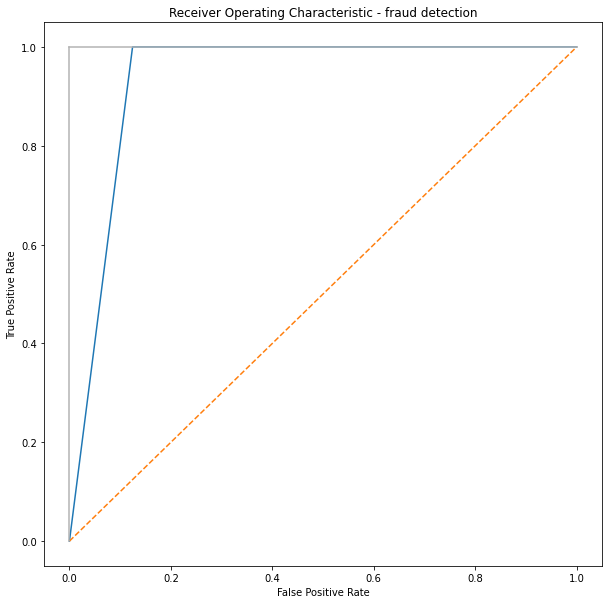

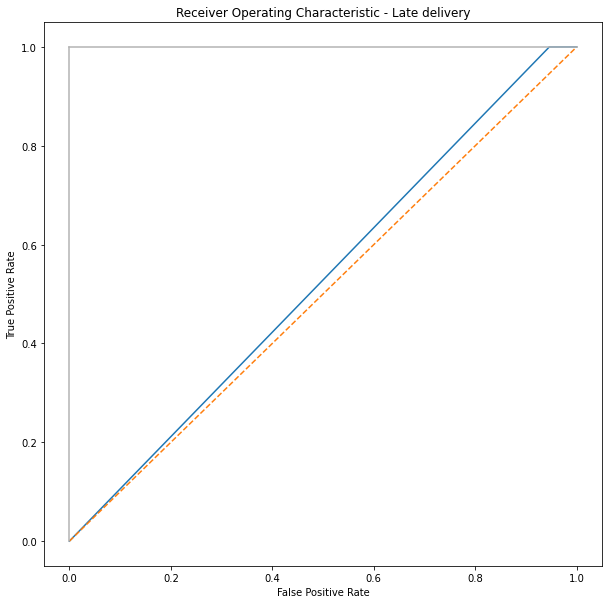

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - fraud detection')
plt.plot(false_positive_rate_f, true_positive_rate_f)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Late delivery')
plt.plot(false_positive_rate_l, true_positive_rate_l)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_f = svm.LinearSVC()
model_l = svm.LinearSVC()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

roc_auc_score for Fraud detection:  0.5964908112220891
roc_auc_score for Late Delivery:  0.9872447415220457
Model paramters used are : LinearSVC()
Accuracy of fraud status is        : 97.76756038112121 %
Recall score of fraud status is        : 57.58620689655173 %
Conf Matrix of fraud status is        :
 [[35131   123]
 [  683   167]]
F1 score of fraud status is        : 29.29824561403509 %
Accuracy of late delivery status is: 98.84777309993352 %
Recall score of late delivery status is: 97.9419185672587 %
Conf Matrix of late delivery status is: 
 [[15891   416]
 [    0 19797]]
F1 score of late delivery status is: 98.96025993501625 %


In [ ]:
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

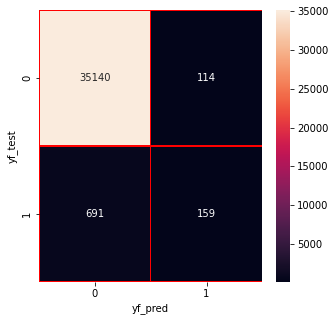

In [ ]:
#confusion matrix visualization
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_f,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yf_pred")
plt.ylabel("yf_test")
plt.show()

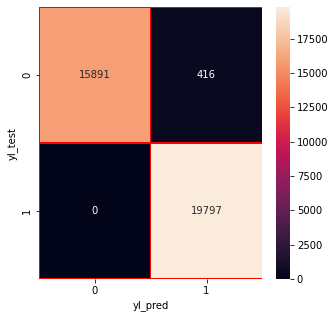

In [ ]:
#confusion matrix visualization

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_l,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yl_pred")
plt.ylabel("yl_test")
plt.show()

In [ ]:
false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection

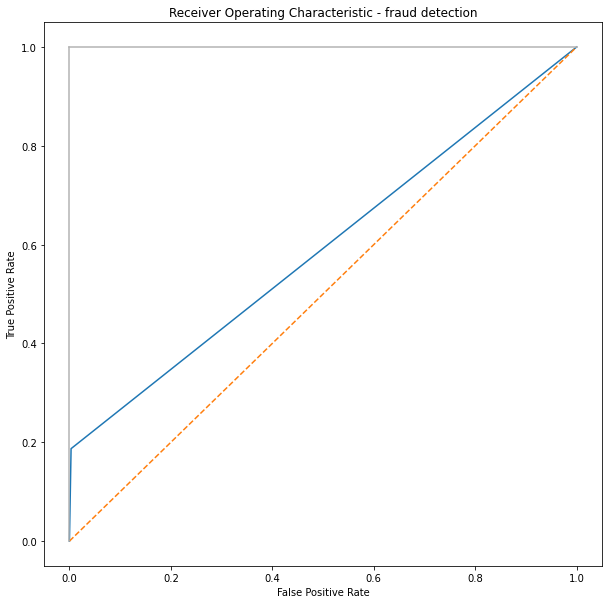

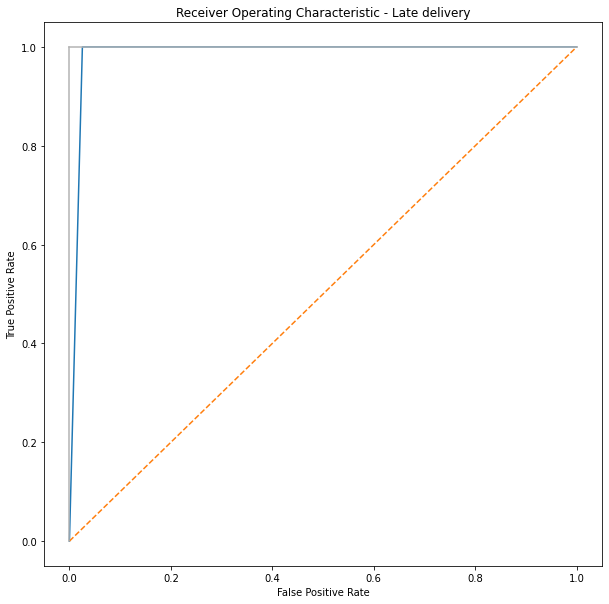

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - fraud detection')
plt.plot(false_positive_rate_f, true_positive_rate_f)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Late delivery')
plt.plot(false_positive_rate_l, true_positive_rate_l)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_f = KNeighborsClassifier(n_neighbors=1)
model_l = KNeighborsClassifier(n_neighbors=1)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

roc_auc_score for Fraud detection:  0.6553973349707501
roc_auc_score for Late Delivery:  0.8030389671824443
Model paramters used are : KNeighborsClassifier(n_neighbors=1)
Accuracy of fraud status is        : 97.38810104143585 %
Recall score of fraud status is        : 42.72300469483568 %
Conf Matrix of fraud status is        :
 [[34888   366]
 [  577   273]]
F1 score of fraud status is        : 36.66890530557421 %
Accuracy of late delivery status is: 80.35674717482827 %
Recall score of late delivery status is: 82.9025741958875 %
Conf Matrix of late delivery status is: 
 [[13006  3301]
 [ 3791 16006]]
F1 score of late delivery status is: 81.86374795417349 %


In [ ]:
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

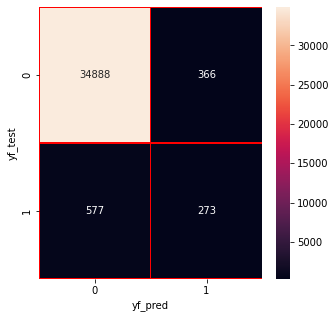

In [ ]:
#confusion matrix visualization
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_f,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yf_pred")
plt.ylabel("yf_test")
plt.show()

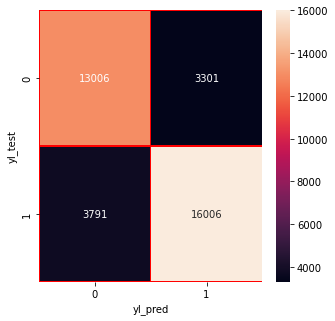

In [ ]:
#confusion matrix visualization

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_l,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yl_pred")
plt.ylabel("yl_test")
plt.show()

In [ ]:
false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection

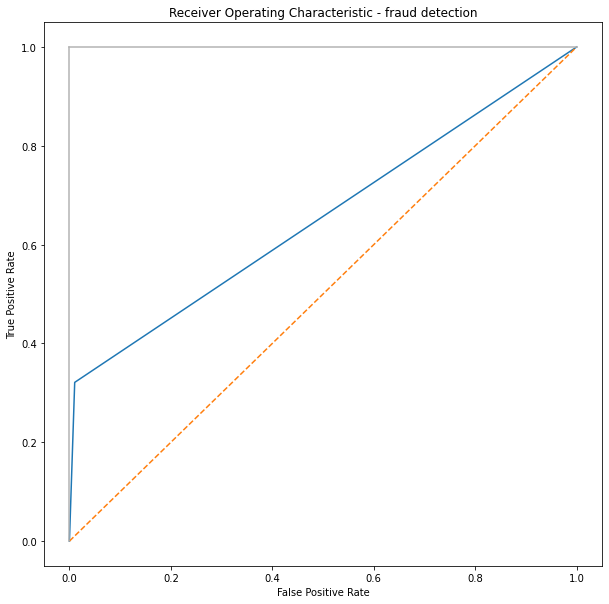

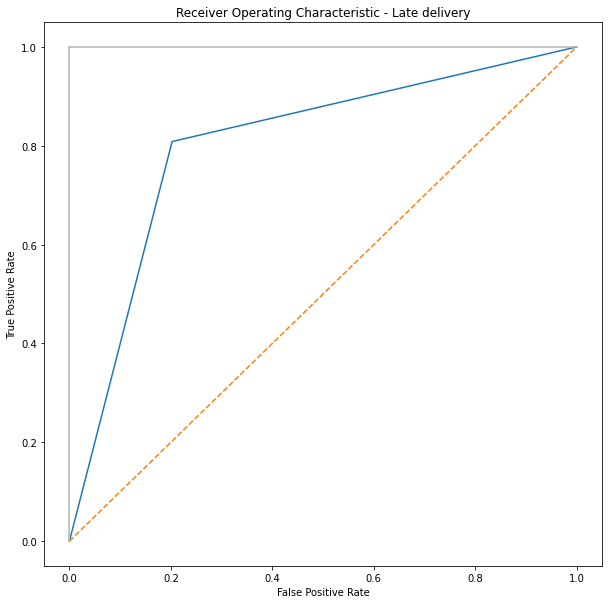

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - fraud detection')
plt.plot(false_positive_rate_f, true_positive_rate_f)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Late delivery')
plt.plot(false_positive_rate_l, true_positive_rate_l)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_f = LinearDiscriminantAnalysis()
model_l = LinearDiscriminantAnalysis()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

roc_auc_score for Fraud detection:  0.715915357122596
roc_auc_score for Late Delivery:  0.982529357221831
Model paramters used are : LinearDiscriminantAnalysis()
Accuracy of fraud status is        : 97.88389098160869 %
Recall score of fraud status is        : 56.49546827794561 %
Conf Matrix of fraud status is        :
 [[34966   288]
 [  476   374]]
F1 score of fraud status is        : 49.47089947089947 %
Accuracy of late delivery status is: 98.36029248836694 %
Recall score of late delivery status is: 97.68585191438646 %
Conf Matrix of late delivery status is: 
 [[15841   466]
 [  126 19671]]
F1 score of late delivery status is: 98.51755396404067 %


In [ ]:
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

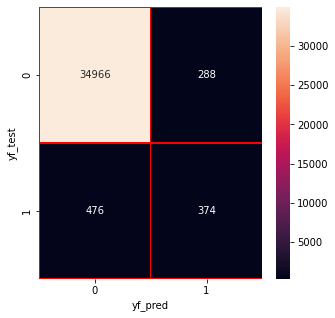

In [ ]:
#confusion matrix visualization
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_f,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yf_pred")
plt.ylabel("yf_test")
plt.show()

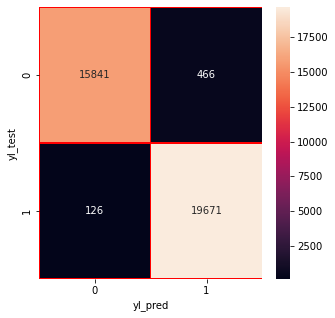

In [ ]:
#confusion matrix visualization

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_l,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yl_pred")
plt.ylabel("yl_test")
plt.show()

In [ ]:
false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection

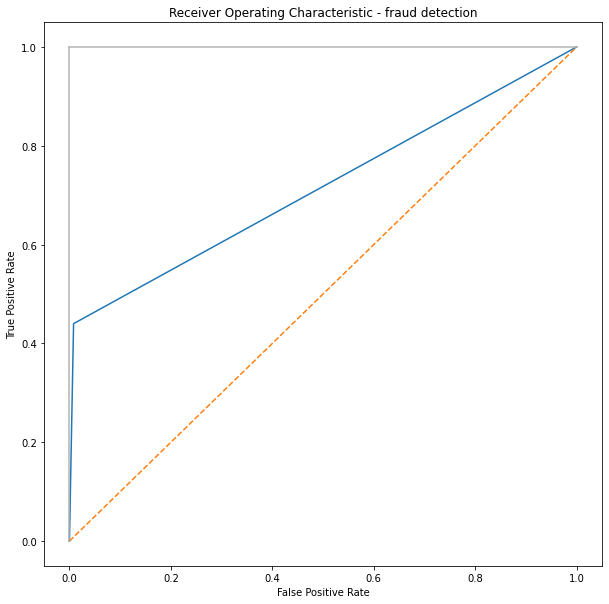

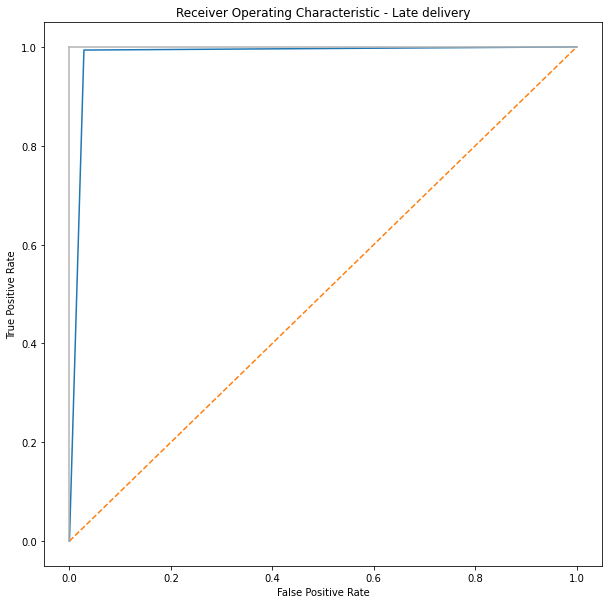

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - fraud detection')
plt.plot(false_positive_rate_f, true_positive_rate_f)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Late delivery')
plt.plot(false_positive_rate_l, true_positive_rate_l)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_f = RandomForestClassifier()
model_l = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)


roc_auc_score for Fraud detection:  0.7199290860611561
roc_auc_score for Late Delivery:  0.9804991721346661
Model paramters used are : RandomForestClassifier()
Accuracy of fraud status is        : 98.66773764679813 %
Recall score of fraud status is        : 98.68073878627969 %
Conf Matrix of fraud status is        :
 [[35249     5]
 [  476   374]]
F1 score of fraud status is        : 60.86248982912937 %
Accuracy of late delivery status is: 98.23842233547529 %
Recall score of late delivery status is: 96.88738804874468 %
Conf Matrix of late delivery status is: 
 [[15671   636]
 [    0 19797]]
F1 score of late delivery status is: 98.41909023117077 %


In [ ]:
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

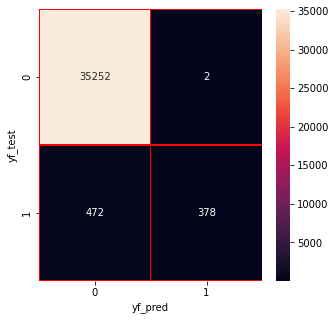

In [ ]:
#confusion matrix visualization
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_f,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yf_pred")
plt.ylabel("yf_test")
plt.show()

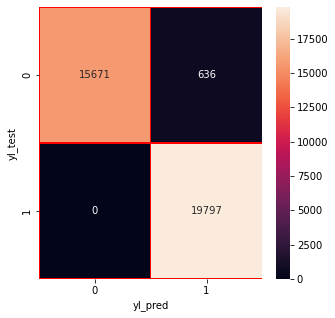

In [ ]:
#confusion matrix visualization

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_l,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yl_pred")
plt.ylabel("yl_test")
plt.show()

In [ ]:
false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection

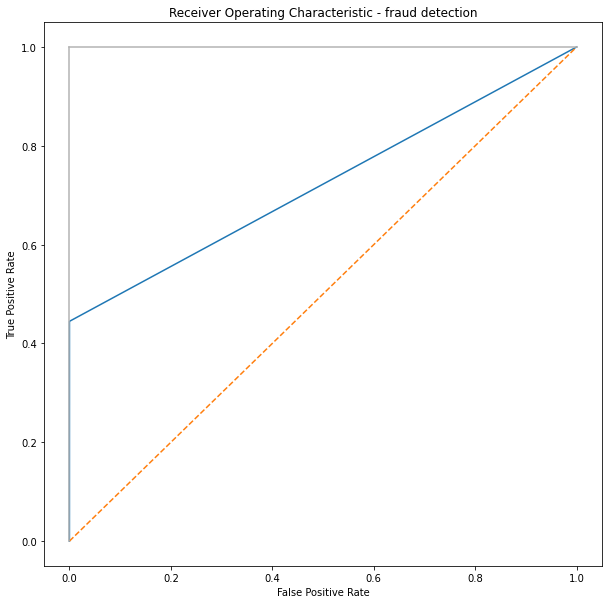

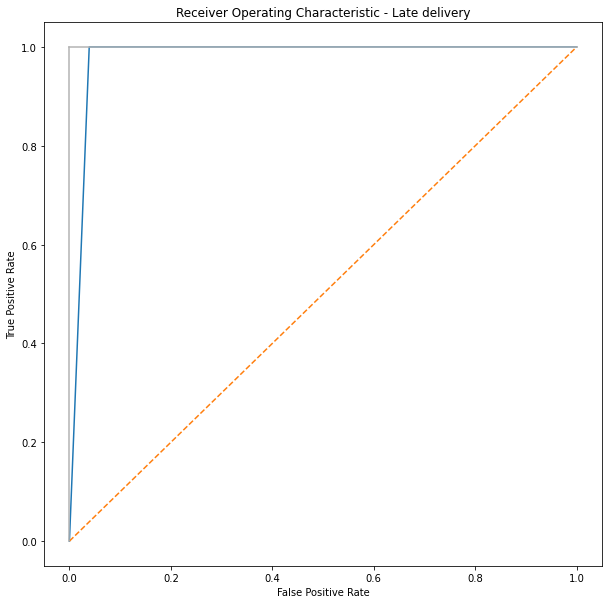

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - fraud detection')
plt.plot(false_positive_rate_f, true_positive_rate_f)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Late delivery')
plt.plot(false_positive_rate_l, true_positive_rate_l)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_f = ExtraTreesClassifier(n_estimators=100, max_depth=None,random_state=0)
model_l = ExtraTreesClassifier(n_estimators=100, max_depth=None,random_state=0)
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

roc_auc_score for Fraud detection:  0.7146916995651724
roc_auc_score for Late Delivery:  0.9907762399379644
Model paramters used are : ExtraTreesClassifier(random_state=0)
Accuracy of fraud status is        : 98.65388876578773 %
Recall score of fraud status is        : 99.72677595628416 %
Conf Matrix of fraud status is        :
 [[35253     1]
 [  485   365]]
F1 score of fraud status is        : 60.0328947368421 %
Accuracy of late delivery status is: 99.16629736317304 %
Recall score of late delivery status is: 98.50716560509554 %
Conf Matrix of late delivery status is: 
 [[16007   300]
 [    1 19796]]
F1 score of late delivery status is: 99.24548166344972 %


In [ ]:
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

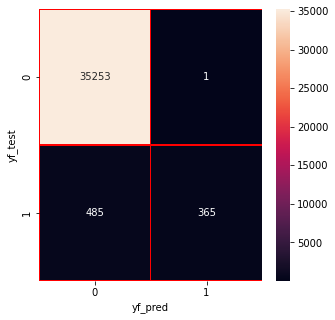

In [ ]:
#confusion matrix visualization
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_f,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yf_pred")
plt.ylabel("yf_test")
plt.show()

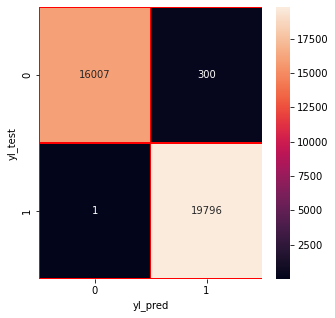

In [ ]:
#confusion matrix visualization

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_l,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yl_pred")
plt.ylabel("yl_test")
plt.show()

In [ ]:
false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection

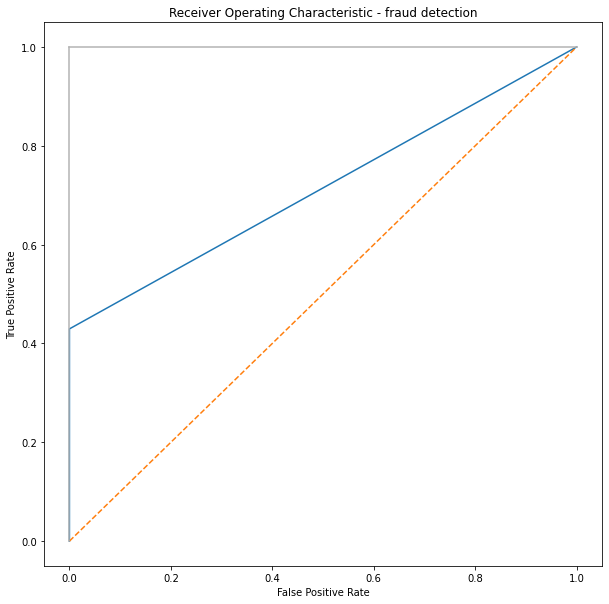

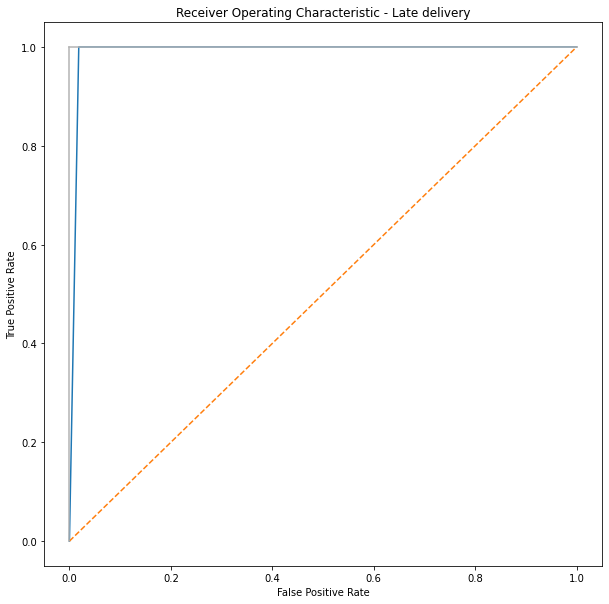

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - fraud detection')
plt.plot(false_positive_rate_f, true_positive_rate_f)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Late delivery')
plt.plot(false_positive_rate_l, true_positive_rate_l)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_f = xgb.XGBClassifier()
model_l = xgb.XGBClassifier()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

roc_auc_score for Fraud detection:  0.5683622384109939
roc_auc_score for Late Delivery:  0.9872447415220457
Model paramters used are : XGBClassifier()
Accuracy of fraud status is        : 97.76756038112121 %
Recall score of fraud status is        : 61.458333333333336 %
Conf Matrix of fraud status is        :
 [[35180    74]
 [  732   118]]
F1 score of fraud status is        : 22.648752399232247 %
Accuracy of late delivery status is: 98.84777309993352 %
Recall score of late delivery status is: 97.9419185672587 %
Conf Matrix of late delivery status is: 
 [[15891   416]
 [    0 19797]]
F1 score of late delivery status is: 98.96025993501625 %


In [ ]:
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

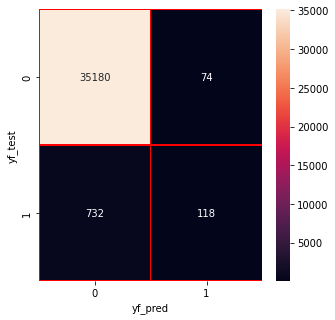

In [ ]:
#confusion matrix visualization
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_f,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yf_pred")
plt.ylabel("yf_test")
plt.show()

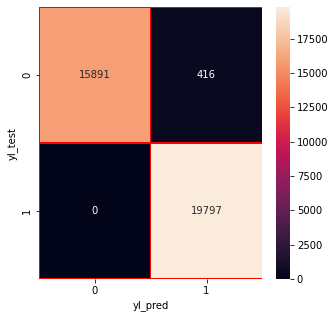

In [ ]:
#confusion matrix visualization

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_l,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yl_pred")
plt.ylabel("yl_test")
plt.show()

In [ ]:
false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection

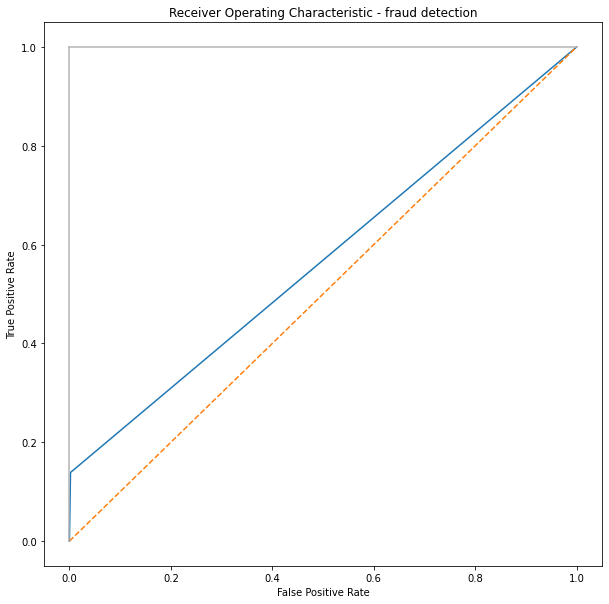

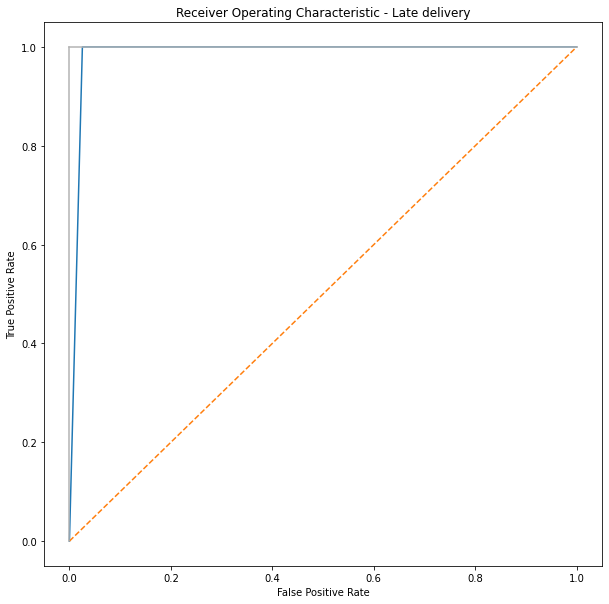

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - fraud detection')
plt.plot(false_positive_rate_f, true_positive_rate_f)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Late delivery')
plt.plot(false_positive_rate_l, true_positive_rate_l)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
model_f = tree.DecisionTreeClassifier()
model_l = tree.DecisionTreeClassifier()
classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)

roc_auc_score for Fraud detection:  0.8919334977424339
roc_auc_score for Late Delivery:  0.9933313086124279
Model paramters used are : DecisionTreeClassifier()
Accuracy of fraud status is        : 99.07489474850432 %
Recall score of fraud status is        : 81.31067961165049 %
Conf Matrix of fraud status is        :
 [[35100   154]
 [  180   670]]
F1 score of fraud status is        : 80.04778972520907 %
Accuracy of late delivery status is: 99.3380234877022 %
Recall score of late delivery status is: 99.40885206143896 %
Conf Matrix of late delivery status is: 
 [[16190   117]
 [  122 19675]]
F1 score of late delivery status is: 99.3962969511733 %


In [ ]:
    model_f=model_f.fit(xf_train,yf_train) # Fitting train data for fraud detection
    model_l=model_l.fit(xl_train,yl_train) # Fitting train data for predection of late delivery
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)# fraud detection
    conf_l=confusion_matrix(yl_test, yl_pred)#predection of late delivery

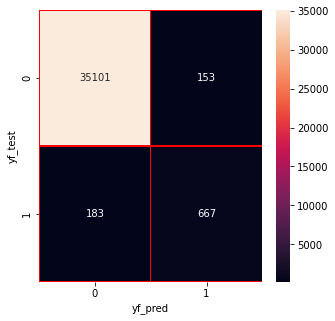

In [ ]:
#confusion matrix visualization
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_f,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yf_pred")
plt.ylabel("yf_test")
plt.show()

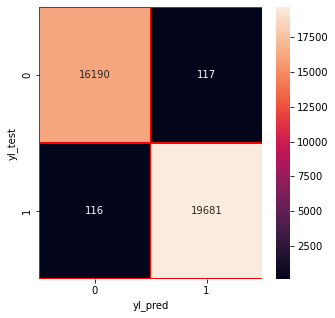

In [ ]:
#confusion matrix visualization

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(conf_l,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("yl_pred")
plt.ylabel("yl_test")
plt.show()

In [ ]:
false_positive_rate_f, true_positive_rate_f, threshold_f = roc_curve(yf_test, yf_pred)#fraud detection
false_positive_rate_l, true_positive_rate_l, threshold_l = roc_curve(yl_test, yl_pred)#late delivery detection

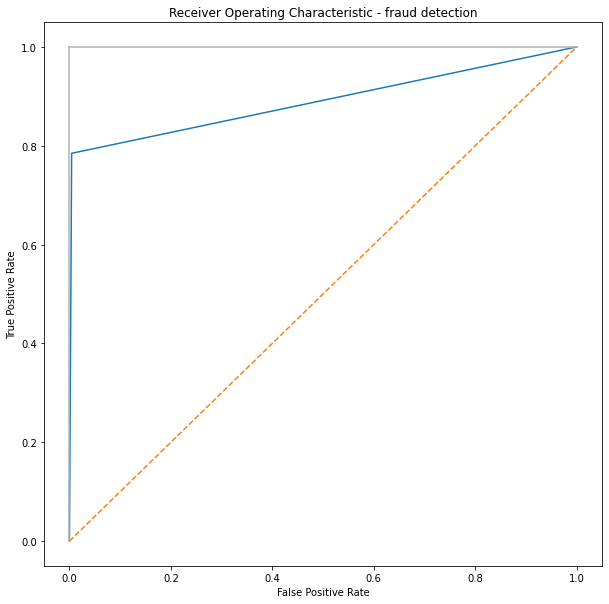

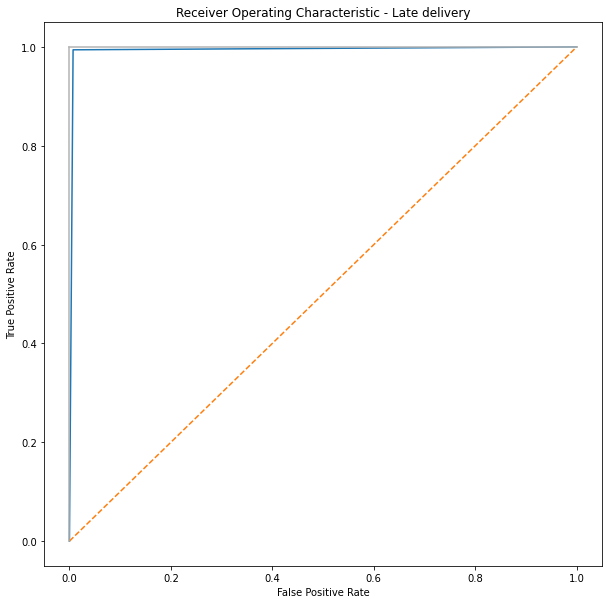

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - fraud detection')
plt.plot(false_positive_rate_f, true_positive_rate_f)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Late delivery')
plt.plot(false_positive_rate_l, true_positive_rate_l)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Giving column Values
classification_data = {'Classification Model':  ['Logistic','Gausian Naive bayes','Support Vector Machines','K nearest Neighbour',
                                'Linear Discriminant Analysis','Random Forest','Extra trees','eExtreme gradient boosting','Decision tree'],
        'Accuracy Score for Fraud Detection':     [97.80,87.84,97.75,97.36,97.88,98.48,98.61,98.93,99.12],
        'Recall Score for Fraud Detection':       [59.40,16.23,56.89,41.90,56.57,93.18,98.88,89.89,82.53],
        'F1 Score for Fraud Detection':           [31.22,27.92,28.42,35.67,49.20,54.57,58.60,73.22,81.00],
        'Accuracy Score for Late Delivery':       [98.84,57.27,98.84,80.82,98.37,98.60,99.17,99.24,99.37],
        'Recall Score for Late Delivery':         [97.94,56.20,97.94,83.45,97.68,97.52,98.51,98.65,99.44],
        'F1 Score for Late Delivery':             [98.96,71.95,98.96,82.26,98.52,98.74,99.25,99.31,99.42] }
#Creating data frame with Column Names
classification_comparision = pd.DataFrame (classification_data, columns = ['Classification Model','Accuracy Score for Fraud Detection','Recall Score for Fraud Detection','F1 Score for Fraud Detection',
                                                                           'Accuracy Score for Late Delivery','Recall Score for Late Delivery','F1 Score for Late Delivery'])

In [ ]:
classification_comparision

,Classification Model,Accuracy Score for Fraud Detection,Recall Score for Fraud Detection,F1 Score for Fraud Detection,Accuracy Score for Late Delivery,Recall Score for Late Delivery,F1 Score for Late Delivery
0,Logistic,97.80,59.40,31.22,98.84,97.94,98.96
1,Gausian Naive bayes,87.84,16.23,27.92,57.27,56.20,71.95
2,Support Vector Machines,97.75,56.89,28.42,98.84,97.94,98.96
3,K nearest Neighbour,97.36,41.90,35.67,80.82,83.45,82.26
4,Linear Discriminant Analysis,97.88,56.57,49.20,98.37,97.68,98.52
5,Random Forest,98.48,93.18,54.57,98.60,97.52,98.74
6,Extra trees,98.61,98.88,58.60,99.17,98.51,99.25
7,eExtreme gradient boosting,98.93,89.89,73.22,99.24,98.65,99.31
8,Decision tree,99.12,82.53,81.00,99.37,99.44,99.42


In [ ]:
classification_comparision.max()

Classification Model                  eExtreme gradient boosting
Accuracy Score for Fraud Detection                         99.12
Recall Score for Fraud Detection                           98.88
F1 Score for Fraud Detection                                81.0
Accuracy Score for Late Delivery                           99.37
Recall Score for Late Delivery                             99.44
F1 Score for Late Delivery                                 99.42
dtype: object

In [ ]:
def cross_validation_model(model_f,model_l,xf,yf,xl,yl):
    model_f= model_f.fit(xf,yf)
    model_l = model_l.fit(xl,yl)
    scores_f = cross_val_score(model_f, xf, yf, cv=6)
    scores_l = cross_val_score(model_l, xl, yl, cv=6)
    print('Model used is',model_f)
    print('Cross validation accuracy of fraud: %0.2f (+/- %0.2f)' % (scores_f.mean(), scores_f.std() * 2))
    print('Cross validation accuracy of late : %0.2f (+/- %0.2f)' % (scores_l.mean(), scores_l.std() * 2))

In [ ]:
cross_validation_model(model_f,model_l,xf,yf,xl,yl)

Model used is DecisionTreeClassifier()
Cross validation accuracy of fraud: 0.96 (+/- 0.04)
Cross validation accuracy of late : 0.98 (+/- 0.02)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text major ticklabel objects>)

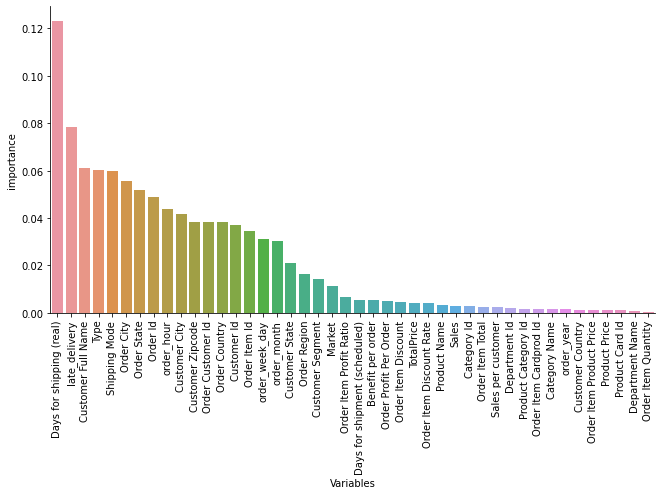

In [ ]:
important_col=model_f.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':xf.columns[important_col],'importance':model_f.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text major ticklabel objects>)

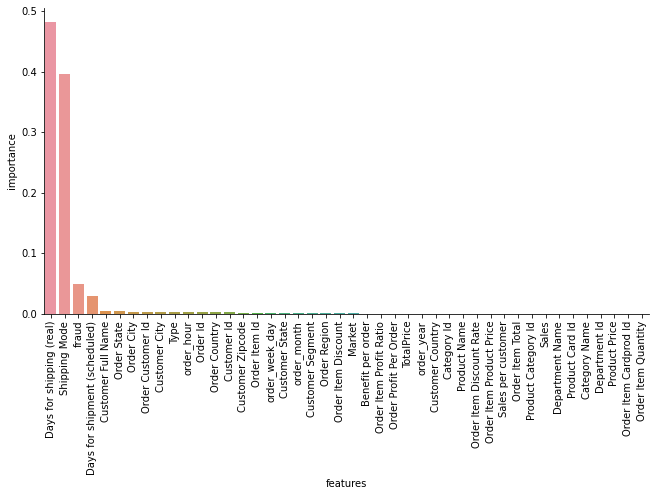

In [ ]:
important_col=model_l.feature_importances_.argsort()
feat_imp=pd.DataFrame({'features':xl.columns[important_col],'importance':model_l.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='features', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

In [ ]:
new_data=train_data.copy()

In [ ]:
new_data=new_data.drop(['Days for shipping (real)','Days for shipment (scheduled)'],axis=1)

In [ ]:
#All columns expect fraud
new_xl=new_data.loc[:, new_data.columns != 'late_delivery']
#Only fraud column
new_yl=train_data['late_delivery']
#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
new_xl_train, new_xl_test,new_yl_train,new_yl_test = train_test_split(new_xl,new_yl,test_size = 0.2,random_state = 42)

In [ ]:
new_xl_train=sc.fit_transform(new_xl_train)
new_xl_test=sc.transform(new_xl_test)

In [ ]:
def New_classifiermodel(model_c,xc_train, xc_test,yc_train,yc_test):
    model_c=model_c.fit(xc_train,yc_train)
    yc_pred=model_c.predict(xc_test)
    accuracy_c=accuracy_score(yc_pred, yc_test)
    recall_c=recall_score(yc_pred, yc_test,average='weighted')
    conf_c=confusion_matrix(yc_test, yc_pred)
    f1_c=f1_score(yc_test, yc_pred,average='weighted')
    print('Model paramters used are :',model_c)
    print('Accuracy         :', (accuracy_c)*100,'%')
    print('Recall score        :', (recall_c)*100,'%')
    print('Conf Matrix        : \n',(conf_c))
    print('F1 score       :', (f1_c)*100,'%')

In [ ]:
new_model_l=tree.DecisionTreeClassifier()
New_classifiermodel(new_model_l,new_xl_train, new_xl_test,new_yl_train,new_yl_test)

Model paramters used are : DecisionTreeClassifier()
Accuracy         : 83.50044316419233 %
Recall score        : 83.50044316419233 %
Conf Matrix        : 
 [[13327  2980]
 [ 2977 16820]]
F1 score       : 83.50030926877294 %


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text major ticklabel objects>)

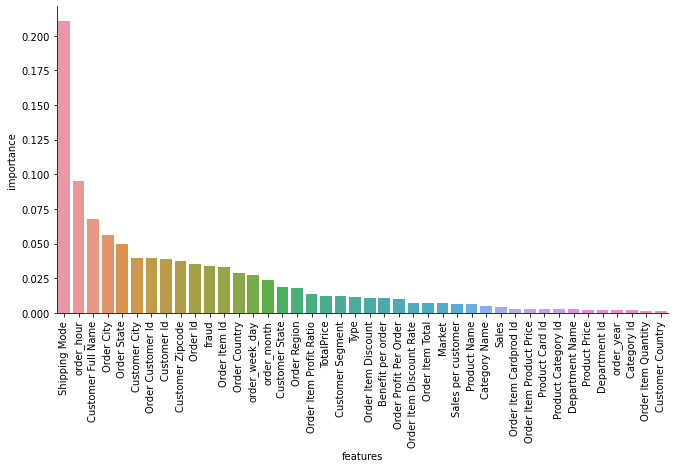

In [ ]:
important_col=new_model_l.feature_importances_.argsort()
feat_imp=pd.DataFrame({'features':new_xl.columns[important_col],'importance':new_model_l.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='features', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

In [ ]:
#All columns expect order country
xc=train_data.loc[:, train_data.columns != 'Order Country']
#Order column country
yc=train_data['Order Country']
#Splitting 20% of dataset as test data
xc_train, xc_test,yc_train,yc_test = train_test_split(xc,yc,test_size = 0.2, random_state = 42)

In [ ]:
xc_train=sc.fit_transform(xc_train)
xc_test=sc.transform(xc_test)

In [ ]:
model_c=tree.DecisionTreeClassifier()
New_classifiermodel(model_c,xc_train, xc_test,yc_train,yc_test)

Model paramters used are : DecisionTreeClassifier()
Accuracy         : 99.78118768003546 %
Recall score        : 99.78118768003546 %
Conf Matrix        : 
 [[  35    0    0 ...    0    0    0]
 [   0    7    0 ...    0    0    0]
 [   0    0 1930 ...    0    0    0]
 ...
 [   0    0    0 ...    4    0    0]
 [   0    0    0 ...    0   45    0]
 [   0    0    0 ...    0    0   47]]
F1 score       : 99.77758691673331 %


In [ ]:
keras.layers.BatchNormalization()
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(1024, activation='relu',kernel_initializer='random_normal', input_dim=44)) #Since we have 44 columns
#Third Hidden Layer
classifier.add(Dense(512, activation='relu',kernel_initializer='random_normal'))
#Fourth Hidden Layer
classifier.add(Dense(256, activation='relu',kernel_initializer='random_normal'))
#Fifth Hidden Layer
classifier.add(Dense(128, activation='relu',kernel_initializer='random_normal'))
#Sixth Hidden Layer
classifier.add(Dense(64, activation='relu',kernel_initializer='random_normal'))
#Seventh Hidden Layer
classifier.add(Dense(32, activation='relu',kernel_initializer='random_normal'))
#Eight Hidden Layer
classifier.add(Dense(16, activation='relu',kernel_initializer='random_normal'))
#Ninth Hidden Layer
classifier.add(Dense(8, activation='relu',kernel_initializer='random_normal'))
#Tenth Hidden Layer
classifier.add(Dense(4, activation='relu',kernel_initializer='random_normal'))
#Eleventh Hidden Layer
classifier.add(Dense(2, activation='relu',kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid',kernel_initializer='random_normal'))

In [ ]:
classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
#Fitting the data to the training dataset
classifier.fit(xf_train,yf_train, batch_size=512, epochs=10)

Epoch 1/10
283/283 [==============================] - 17s 57ms/step - loss: 0.6066 - accuracy: 0.9749
Epoch 2/10
283/283 [==============================] - 16s 56ms/step - loss: 0.3964 - accuracy: 0.9778
Epoch 3/10
283/283 [==============================] - 16s 56ms/step - loss: 0.2379 - accuracy: 0.9778
Epoch 4/10
283/283 [==============================] - 16s 56ms/step - loss: 0.1604 - accuracy: 0.9778
Epoch 5/10
283/283 [==============================] - 16s 56ms/step - loss: 0.1280 - accuracy: 0.9778
Epoch 6/10
283/283 [==============================] - 16s 56ms/step - loss: 0.1150 - accuracy: 0.9778
Epoch 7/10
283/283 [==============================] - 16s 56ms/step - loss: 0.1097 - accuracy: 0.9778
Epoch 8/10
283/283 [==============================] - 16s 56ms/step - loss: 0.1077 - accuracy: 0.9778
Epoch 9/10
283/283 [==============================] - 16s 56ms/step - loss: 0.1070 - accuracy: 0.9778
Epoch 10/10
283/283 [==============================] - 16s 56ms/step - loss: 0.106

In [ ]:
classifier.fit(xf_train,yf_train, batch_size=512, epochs=30)

Epoch 1/30
283/283 [==============================] - 16s 56ms/step - loss: 0.1067 - accuracy: 0.9778
Epoch 2/30
283/283 [==============================] - 16s 56ms/step - loss: 0.1066 - accuracy: 0.9778
Epoch 3/30
283/283 [==============================] - 16s 56ms/step - loss: 0.1066 - accuracy: 0.9778
Epoch 4/30
283/283 [==============================] - 16s 56ms/step - loss: 0.1066 - accuracy: 0.9778
Epoch 5/30
283/283 [==============================] - 16s 57ms/step - loss: 0.1066 - accuracy: 0.9778
Epoch 6/30
283/283 [==============================] - 18s 64ms/step - loss: 0.1066 - accuracy: 0.9778
Epoch 7/30
283/283 [==============================] - 16s 57ms/step - loss: 0.1066 - accuracy: 0.9778
Epoch 8/30
283/283 [==============================] - 16s 57ms/step - loss: 0.1066 - accuracy: 0.9778
Epoch 9/30
283/283 [==============================] - 16s 56ms/step - loss: 0.1067 - accuracy: 0.9778
Epoch 10/30
283/283 [==============================] - 16s 56ms/step - loss: 0.106

In [ ]:
train_evaluate=classifier.evaluate(xf_train, yf_train)
test_evaluate=classifier.evaluate(xf_test, yf_test)
print('accuracy for Train set is',train_evaluate)
print('accuracy for Test set is',test_evaluate)# evaluation of model.
yf_pred1=classifier.predict(xf_test,batch_size=512,verbose=1)
yf_pred=np.argmax(yf_pred1,axis=1)
print(f1_score(yf_test,yf_pred,average="weighted"))

1129/1129 [==============================] - 5s 4ms/step - loss: 0.1117 - accuracy: 0.9765
accuracy for Train set is [0.1066814661026001, 0.977758526802063]
accuracy for Test set is [0.1116834431886673, 0.976456880569458]
71/71 [==============================] - 1s 19ms/step
0.9648255733921929


sales and product quantity prediction

In [ ]:
xs=train_data.loc[:, train_data.columns != 'Sales']
ys=train_data['Sales']
xs_train, xs_test,ys_train,ys_test = train_test_split(xs,ys,test_size = 0.3, random_state = 42)
xq=train_data.loc[:, train_data.columns != 'Order Item Quantity']
yq=train_data['Order Item Quantity']
xq_train, xq_test,yq_train,yq_test = train_test_split(xq,yq,test_size = 0.3, random_state = 42)

In [ ]:
scaler=MinMaxScaler()
xs_train=scaler.fit_transform(xs_train)
xs_test=scaler.transform(xs_test)
xq_train=scaler.fit_transform(xq_train)
xq_test=scaler.transform(xq_test)

In [ ]:
def regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test):
    model_s=model_s.fit(xs_train,ys_train)#Fitting train data for sales
    model_q=model_q.fit(xq_train,yq_train)#Fitting train data for order quantity
    ys_pred=model_s.predict(xs_test)#predicting sales with test data
    yq_pred=model_q.predict(xq_test)#predicting order quantity with test data
    print('Model parameter used are:',model_s) #Printing the model to see which parameters are used
    #Printing mean absolute error for predicting sales
    print("MAE of sales is         :", metrics.mean_absolute_error(ys_test,ys_pred))
    #Printing Root mean squared error for predicting sales
    print("RMSE of sales is        :",np.sqrt(metrics.mean_squared_error(ys_test,ys_pred)))
    #Printing mean absolute error for predicting order quantity
    print("MAE of order quantity   :", metrics.mean_absolute_error(yq_test,yq_pred))
    #Printing Root mean squared error for predicting order quantity
    print("RMSE of order quantity  :",np.sqrt(metrics.mean_squared_error(yq_test,yq_pred)))

In [ ]:
model_s = linear_model.Lasso(alpha=0.1)
model_q = linear_model.Lasso(alpha=0.1)
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: Lasso(alpha=0.1)
MAE of sales is         : 1.5543249732525921
RMSE of sales is        : 2.3330668537282264
MAE of order quantity   : 0.9045863703745013
RMSE of order quantity  : 1.0305321636898375


In [ ]:
model_s = Ridge(alpha=1.0)
model_q = Ridge(alpha=1.0)
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: Ridge()
MAE of sales is         : 0.7550980275645373
RMSE of sales is        : 0.9797923327190609
MAE of order quantity   : 0.34598281200905096
RMSE of order quantity  : 0.5221095120349866


In [ ]:
model_s = lgb.LGBMRegressor()
model_q = lgb.LGBMRegressor()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: LGBMRegressor()
MAE of sales is         : 0.4608967314236202
RMSE of sales is        : 1.6694322183572285
MAE of order quantity   : 0.0015026406737609238
RMSE of order quantity  : 0.01083017104892248


In [ ]:
model_s = RandomForestRegressor(n_estimators=100,max_depth=10, random_state=40)
model_q = RandomForestRegressor(n_estimators=100,max_depth=10, random_state=40)
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

In [ ]:
model_s = xgb.XGBRegressor()
model_q = xgb.XGBRegressor()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

[19:48:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:49:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model parameter used are: XGBRegressor()
MAE of sales is         : 1.7835266228264823
RMSE of sales is        : 3.953767965247966
MAE of order quantity   : 0.024706041038507407
RMSE of order quantity  : 0.05133089126585871


In [ ]:
model_s = tree.DecisionTreeRegressor()
model_q = tree.DecisionTreeRegressor()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: DecisionTreeRegressor()
MAE of sales is         : 0.013874179136280262
RMSE of sales is        : 0.9327751439224053
MAE of order quantity   : 5.5395524041657433e-05
RMSE of order quantity  : 0.007442816942640564


In [ ]:
model_s=LinearRegression()
model_q=LinearRegression()
regressionmodel(model_s,model_q,xs_train, xs_test,ys_train,ys_test,xq_train, xq_test,yq_train,yq_test)

Model parameter used are: LinearRegression()
MAE of sales is         : 0.0005995640728439641
RMSE of sales is        : 0.001478329241598482
MAE of order quantity   : 0.3420250632841426
RMSE of order quantity  : 0.5215434813001418


In [ ]:
#Giving column Values
Regression_data = {'Regression Model':  ['Lasso','Ridge','Light Gradient Boosting','Random Forest',
                                 'eXtreme gradient boosting','Decision tree','Linear Regression'],
        'MAE Value for Sales' :        [1.55,0.75,0.46,0.19,0.154,0.013,0.0005],
        'RMSE Value for Sales':        [2.33,0.97,1.66,1.79,3.13,0.918,0.0014],
        'MAE Value for Quantity' :     [0.90,0.34,0.001,0.0001,0.0005,3.69,0.34],
        'RMSE Value for Quantity':     [1.03,0.52,0.011,0.006,0.004,0.006,0.52] }
#Creating data frame with Column Names
Regression_comparision = pd.DataFrame (Regression_data, columns = ['Regression Model','MAE Value for Sales','RMSE Value for Sales',
        'MAE Value for Quantity','RMSE Value for Quantity'])

In [ ]:
Regression_comparision #Printing dataframe

,Regression Model,MAE Value for Sales,RMSE Value for Sales,MAE Value for Quantity,RMSE Value for Quantity
0,Lasso,1.5500,2.3300,0.9000,1.030
1,Ridge,0.7500,0.9700,0.3400,0.520
2,Light Gradient Boosting,0.4600,1.6600,0.0010,0.011
3,Random Forest,0.1900,1.7900,0.0001,0.006
4,eXtreme gradient boosting,0.1540,3.1300,0.0005,0.004
5,Decision tree,0.0130,0.9180,3.6900,0.006
6,Linear Regression,0.0005,0.0014,0.3400,0.520


In [ ]:
Regression_comparision.min()

Regression Model           Decision tree
MAE Value for Sales               0.0005
RMSE Value for Sales              0.0014
MAE Value for Quantity            0.0001
RMSE Value for Quantity            0.004
dtype: object

In [ ]:
regressor = Sequential()

#First Hidden Layer
regressor.add(Dense(512, activation='relu',kernel_initializer='normal',input_dim=44))
#Second  Hidden Layer
regressor.add(Dense(256, activation='relu',kernel_initializer='normal'))
#Third  Hidden Layer
regressor.add(Dense(256, activation='relu',kernel_initializer='normal'))
#Fourth  Hidden Layer
regressor.add(Dense(256, activation='relu',kernel_initializer='normal'))
#Fifth  Hidden Layer
regressor.add(Dense(256, activation='relu',kernel_initializer='normal'))

#Output Layer
regressor.add(Dense(1, activation='linear'))# Linear activation is used.


In [ ]:
regressor.compile(optimizer='adam',loss='mean_absolute_error',metrics=['mean_absolute_error'])

In [ ]:
#Fitting the data to the training dataset
regressor.fit(xq_train,yq_train, batch_size=256, epochs=10)

Epoch 1/10
494/494 [==============================] - 10s 18ms/step - loss: 0.2604 - mean_absolute_error: 0.2604
Epoch 2/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0857 - mean_absolute_error: 0.0857
Epoch 3/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0712 - mean_absolute_error: 0.0712
Epoch 4/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0557 - mean_absolute_error: 0.0557
Epoch 5/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0539 - mean_absolute_error: 0.0539
Epoch 6/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0433 - mean_absolute_error: 0.0433
Epoch 7/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0374 - mean_absolute_error: 0.0374
Epoch 8/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0321 - mean_absolute_error: 0.0321
Epoch 9/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0305 - mean_absolute_error

In [ ]:
regressor.fit(xq_train,yq_train, batch_size=256, epochs=50)

Epoch 1/50
494/494 [==============================] - 9s 18ms/step - loss: 0.0313 - mean_absolute_error: 0.0313
Epoch 2/50
494/494 [==============================] - 9s 18ms/step - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 3/50
494/494 [==============================] - 9s 18ms/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 4/50
494/494 [==============================] - 9s 18ms/step - loss: 0.0239 - mean_absolute_error: 0.0239
Epoch 5/50
494/494 [==============================] - 9s 18ms/step - loss: 0.0249 - mean_absolute_error: 0.0249
Epoch 6/50
494/494 [==============================] - 9s 17ms/step - loss: 0.0214 - mean_absolute_error: 0.0214
Epoch 7/50
494/494 [==============================] - 9s 18ms/step - loss: 0.0236 - mean_absolute_error: 0.0236
Epoch 8/50
494/494 [==============================] - 9s 17ms/step - loss: 0.0212 - mean_absolute_error: 0.0212
Epoch 9/50
494/494 [==============================] - 9s 17ms/step - loss: 0.0230 - mean_absolute_error:

In [ ]:
#Fitting the data to the training dataset
regressor.fit(xq_train,yq_train, batch_size=256, epochs=10)

Epoch 1/10
494/494 [==============================] - 9s 17ms/step - loss: 0.0088 - mean_absolute_error: 0.0088
Epoch 2/10
494/494 [==============================] - 9s 17ms/step - loss: 0.0089 - mean_absolute_error: 0.0089
Epoch 3/10
494/494 [==============================] - 9s 17ms/step - loss: 0.0087 - mean_absolute_error: 0.0087
Epoch 4/10
494/494 [==============================] - 9s 17ms/step - loss: 0.0081 - mean_absolute_error: 0.0081
Epoch 5/10
494/494 [==============================] - 9s 18ms/step - loss: 0.0086 - mean_absolute_error: 0.0086
Epoch 6/10
494/494 [==============================] - 9s 17ms/step - loss: 0.0075 - mean_absolute_error: 0.0075
Epoch 7/10
494/494 [==============================] - 9s 17ms/step - loss: 0.0088 - mean_absolute_error: 0.0088
Epoch 8/10
494/494 [==============================] - 9s 17ms/step - loss: 0.0085 - mean_absolute_error: 0.0085
Epoch 9/10
494/494 [==============================] - 9s 17ms/step - loss: 0.0090 - mean_absolute_error:

In [ ]:
pred_train_q= regressor.predict(xq_train)
pred_q_test= regressor.predict(xq_test)
print('MAE Value train data:',regressor.evaluate(xq_train,yq_train))
print('RMSE of train data:',np.sqrt(mean_squared_error(yq_train,pred_train_q)))
print('MAE Value test data:',regressor.evaluate(xq_test,yq_test))
print('RMSE of test data:',np.sqrt(mean_squared_error(yq_test,pred_q_test)))

3949/3949 [==============================] - 10s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0072
MAE Value train data: [0.007231510244309902, 0.007231510244309902]
RMSE of train data: 0.02101030461523108
1693/1693 [==============================] - 4s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0071
MAE Value test data: [0.007054363377392292, 0.007054363377392292]
RMSE of test data: 0.020802605548795074
